In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.special import binom 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
from torch.autograd import Variable
import torch.utils.data as data_utils
import torch.nn.init as init

from collections import Counter
import operator
import copy 
from itertools import product,combinations
from time import time 
#from IPython.core.display import display

%matplotlib inline

## code extracted from https://www.kaggle.com/code/graymant/breast-cancer-diagnosis-with-pytorch
## SV code extracted from https://github.com/mburaksayici/ExplainableAI-Pure-Numpy/blob/main/KernelSHAP-Pure-Numpy.ipynb

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#from utils import read_data,label_mapping_FEMNIST
from utils import *
from models import Net, Federated_Averaging, Global_Model,Local_Model,AFPL,training_loop
from data import FEMNIST_dataset, Partition_MNIST_NIID,MNIST_NIID_dataset
import keras

import yaml 
stream = 'settings\train_settings.yaml'
with open('settings/train_settings.yaml','r') as file:
    settings = yaml.safe_load(file)
    
print(settings)
### Divide MNIST dataset over a total of 10 clients. Each client gets 2 classes.
train_data, test_data = keras.datasets.mnist.load_data()
instance = Partition_MNIST_NIID(train_data[0],train_data[1])
classes_per_user = 2
total_clients = 12
train_partition = instance.create_partition(4,classes_per_user,total_clients)
test_instance = Partition_MNIST_NIID(test_data[0], test_data[1])
test_partition = test_instance.create_partition_test(instance.sample_array)

2023-03-10 13:04:05.953534: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


{'experiment_name': 'test_adaptive_a4', 'Date': '22_11_2022', 'Dataset': 'MNIST_niid', 'n_clients': 10, 'total_clients': 10, 'classes_per_user': 10, 'network': 'Net', 'n_epochs': 100, 'local_iterations': 1, 'type': 'afpl', 'log_interval': 25}
[[1 2]
 [0 1]
 [0 1]
 [3 1]
 [3 0]
 [0 1]
 [0 1]
 [3 2]
 [0 2]
 [3 1]
 [1 2]
 [0 1]]


In [3]:
# SHAP kernel 

class SHAP_kernel(object): 
    def __init__(self,n_clients,samples,verbose=True):
        self.samples = samples 
        self.n_clients = n_clients 
        self.verbose = verbose 
        self.indices = []
        
    def first_guess(self): 
        self.shap_weights = [(self.n_clients-1)/(z*(self.n_clients-z)) for z in list(range(1,self.n_clients))]
        self.discrete_shap = np.round(self.shap_weights/np.sum(self.shap_weights)*self.samples)
        
    def adjust_if_necessary(self,shap_kernel):
        ddd = copy.copy(shap_kernel)
        
        self.changed = False 
        for i,ele in enumerate(shap_kernel):
            if i not in self.indices: 
                binom_i = binom(len(shap_kernel)+1,i+1)
                if binom_i < ele: 
                    self.changed = True 
                    ddd[i] = binom_i
                    self.indices.append(i)
        #print(ddd)
        if self.changed == True: 
            n = self.samples - np.sum(ddd)
            p = np.sum(ddd) - np.sum(ddd[self.indices])
            if p != 0: 
                self.adjusted = np.round(ddd * (n+p)/p)
                self.adjusted[self.indices] = ddd[self.indices]
            else: 
                self.adjusted = ddd 
                #self.changed = False

    def weights(self):
        
        if self.changed == True: 
            while self.changed == True: 
                self.adjust_if_necessary(self.adjusted)
                
            self.discrete_shap = self.adjusted 
                
            weights = (1/len(self.discrete_shap))*np.ones(np.shape(self.discrete_shap))
            changes = self.discrete_shap/self.adjusted
            weights = weights*changes 
            self.weights = weights / np.sum(weights)
            if self.verbose == True: 
                fig,ax = plt.subplots(2,2)
                plt.tight_layout()
                ax[0,0].plot(np.arange(1,self.n_clients),self.adjusted)
                ax[0,0].title.set_text("number of coalitions with k clients")
                ax[0,1].plot(np.arange(1,self.n_clients),weights)
                ax[0,1].title.set_text("weights")
                ax[1,0].plot(np.arange(1,self.n_clients),self.adjusted*weights)
                ax[1,0].title.set_text("# coalitions * weights")
                ax[1,1].plot(np.arange(1,self.n_clients),self.shap_weights)
                ax[1,1].title.set_text("exact Shapley kernel")
                
                print("weights: ",weights)
                print("we took: ",int(np.sum(self.adjusted))," samples instead of ",self.samples," samples")
                print(np.sum(weights))
        else: 
            # uniform weights 
            self.weights = (1/len(self.discrete_shap))*np.ones(np.shape(self.discrete_shap))
            if self.verbose == True: 
                print("weights: ",weights)
                plt.plot(self.discrete_shap*weights)
                print("we took: ",int(np.sum(self.discrete_shap))," samples instead of ",self.samples," samples")
        
    def forward_shap(self): 
        self.first_guess()
        self.adjust_if_necessary(shap_kernel=self.discrete_shap)
        self.weights()

class create_coalitions(object):
    def __init__(self,discrete_shap,weights,n_clients):
        self.actual_samples = int(np.sum(discrete_shap))
        self.discrete_shap = discrete_shap
        self.weights = weights 
        self.n_clients = n_clients 

    def combiner(self,used_masks,i_old,zeros=3,ones=2):
        for i,indices in enumerate(combinations(range(zeros+ones),ones)):
            item = ['0']*(zeros+ones)
            for index in indices: 
                item[index] = '1'
            used_masks[''.join(item)] = int(i_old + i +1)

    # determine the permutation length weighted by SV 
    def permutation_length(self): 
        arr = np.zeros(self.actual_samples)
        K_old = 0 
        for i,K in enumerate(self.discrete_shap): 
            arr[int(K_old):int(K+K_old)] = int(i)
            K_old += K 
        #np.random.shuffle(arr)
        return arr
    
    def forward(self): 
        indices = self.permutation_length()

        mask = np.zeros(self.n_clients)
        used_masks = {}
        kernel_weights = {}
        full_clients = []
        number_masks = 0 
        for i in range(self.actual_samples):
            mask.fill(0.0)

            ind = indices[i] + 1
            kernel_weights[i] = self.weights[int(indices[i])]
            if binom(self.n_clients,ind) <= self.discrete_shap[int(indices[i])]:
                # list all permutations. 
                if ind not in full_clients: 
                    full_clients.append(ind)
                    self.combiner(used_masks,number_masks,self.n_clients-int(ind),int(ind))
                    number_masks += binom(self.n_clients,ind)

            else: 

                number_masks_after = number_masks + 1 
                time_before = time()
                while number_masks != number_masks_after: 
                    mask.fill(0.0)
                    perm = np.random.permutation(self.n_clients)[:int(ind)]
                    mask[perm] = 1
                    tuple_m = ''.join(str(int(x)) for x in mask)
                    if tuple_m not in used_masks: 
                        used_masks[tuple_m] = int(number_masks)
                        number_masks += 1 
                    time_int = time()
                    if time_int > time_before + 0.05: 
                        print("failed to find all permutations")
                        break
                        
        masks = np.zeros((self.actual_samples,self.n_clients))
        weights = np.zeros(self.actual_samples)
        for i,coalition in enumerate(used_masks.keys()):
            masks[i,:] = np.array(list(coalition))#int(coalition,2)
            weights[i] = kernel_weights[i]
        weights = weights / np.sum(weights)
        return masks,weights
                        
#coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
#masks,weights = coalition_object.forward()
#print(masks)
#print(weights)

In [4]:
class Net(nn.Module):
    def __init__(self,dataset,out=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        if dataset == 'FEMNIST':
            self.fc2 = nn.Linear(100, 62)
        if dataset == 'MNIST_niid':
            self.fc2 = nn.Linear(100,out)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=-1)

In [5]:
from torch.utils.data import DataLoader
import copy
network = Net('MNIST_niid')
client_models = {}
optimizers = {}
dataloaders = {}
dataloaders_test = {}
for i in range(total_clients):
    client_models[str(i)] = copy.deepcopy(network).double().cuda()
    optimizers[str(i)] = torch.optim.SGD(client_models[str(i)].parameters(),lr=0.01,momentum=0.5)
    dataset_train= MNIST_NIID_dataset(train_data[0],train_data[1],train_partition,i)
    dataloaders[str(i)] = DataLoader(dataset_train,batch_size=16,shuffle=True)
    dataset_test= MNIST_NIID_dataset(test_data[0],test_data[1],test_partition,i)
    dataloaders_test[str(i)] = DataLoader(dataset_test,batch_size=16,shuffle=True)

In [6]:
import random
# Select 5 clients 
selected_clients = [1,2,5,6] #[4,8,9]
# create a (random) graph between them
graph = []
for index,sample in enumerate(selected_clients):
    other_clients = copy.deepcopy(selected_clients)
    other_clients.remove(sample)
    l = [i for i in other_clients]
    graph.append(random.sample(l,k=2))
    
print(graph)

[[2, 6], [1, 6], [2, 1], [2, 1]]


In [7]:
class P2P_AFPL():
    def __init__(self,total_clients,train_data,train_partition,test_data,test_partition): 
        self.network = Net('MNIST_niid')
        self.total_clients = total_clients 
        self.client_models = {}
        self.optimizers = {}
        self.dataloaders = {}
        self.len = {}
        self.len_test = {}
        self.dataloaders_test = {}
        for i in range(total_clients):
            self.client_models[str(i)] = copy.deepcopy(network).double().cuda()
            self.optimizers[str(i)] = torch.optim.SGD(self.client_models[str(i)].parameters(),lr=0.01,momentum=0.5)
            dataset_train= MNIST_NIID_dataset(train_data[0],train_data[1],train_partition,i)
            self.len[str(i)]= len(dataset_train)
            self.dataloaders[str(i)] = DataLoader(dataset_train,batch_size=16,shuffle=True)
            dataset_test= MNIST_NIID_dataset(test_data[0],test_data[1],test_partition,i)
            self.len_test[str(i)] = len(dataset_test)
            self.dataloaders_test[str(i)] = DataLoader(dataset_test,batch_size=16,shuffle=True)
            
    def create_graph(self,selected_clients):
        graph = []
        for index,sample in enumerate(selected_clients):
            other_clients = copy.deepcopy(selected_clients)
            other_clients.remove(sample)
            l = [i for i in other_clients]
            graph.append(random.sample(l,k=2))

        return graph 
    
    def select_clients(self, n_clients=1,total_clients=1, seed=1):
        random.seed(seed)
        l = [i for i in range(total_clients)]
        self.selected_clients = random.sample(l,k=n_clients)
        return self.selected_clients 

    def update_local_models(self,selected_clients):
        self.dw = {}
        for idx,i in enumerate(selected_clients):
            #print("local model i",i)
            dataloader = self.dataloaders[str(i)]
            self.client_models[str(i)].train()
            
            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target=target.long().cuda()

                self.optimizers[str(i)].zero_grad()
                output = self.client_models[str(i)](data)
                loss = F.nll_loss(output,target)
                loss.backward()
                self.optimizers[str(i)].step()
            
            self.client_models[str(i)].eval()
            dataloader_test = self.dataloaders_test[str(i)]
            loss_test = 0 
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader_test):
                    data = data.double().cuda()
                    target=target.long().cuda()

                    output = self.client_models[str(i)](data)
                    loss_test += F.nll_loss(output,target)
            #print("loss test",loss_test)
            
            loss_test2 = 0 
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader):
                    data = data.double().cuda()
                    target=target.long().cuda()

                    output = self.client_models[str(i)](data)
                    loss_test2 += F.nll_loss(output,target)
            #print("loss train",loss_test2)
            
        return loss_test/self.len_test[str(i)],loss_test2 /self.len[str(i)]
    
    

            
    def combine_models(self,i,client_numbers):
        zero_copy = copy.deepcopy(self.client_models[str(i)]) # This is used to collect the model in
        j =0
        client_numbers_plus_client = client_numbers + [i] # This is more efficient
        alphas = zero_copy.alphas.detach()
        alphas[i] = 1 - torch.sum(
            torch.tensor([iii for idx, iii in enumerate(alphas) if idx != i and idx in client_numbers]))
        # It's not possible to set the value of self.alphas[i], so instead we determine it manually here

        for ii in client_numbers_plus_client:

            for (name, param),(name2,param2) in zip(zero_copy.named_parameters(),self.client_models[str(ii)].named_parameters()): #self.client_models[str(ii)].named_parameters()):

                if name != 'alphas':
                    if j == 0:
                        param.data = torch.zeros(param.shape).cuda()

                    param.data += alphas[ii]*param2.data # we add all participating client's models to the one here.

            j += 1

        self.client_models[str(i)] = zero_copy.double()
        
    def calc_accuracy(self):
        
        for i in self.selected_clients: 
            dataloader = self.dataloaders_test[str(i)]
            intermediate_accuracy = 0 

            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output_array = output.detach().cpu().numpy()
                output_class = np.argmax(output_array,axis=-1)
                target_array = target.detach().cpu().numpy()
                intermediate_accuracy += np.sum(output_class == target_array)

            accuracy = intermediate_accuracy/p2p.len_test[str(i)]*100
            print(i)
            print(accuracy)
            
    def federated_averaging(self):
        self.shared_model = copy.deepcopy(network).double().cuda()
        n_clients = len(self.selected_clients)
        weight = [self.len[str(x)] for x in self.selected_clients]
        weight = weight / np.sum(weight)
        #print("weights ",weight)
        for idx,i in enumerate(self.selected_clients): 
            for (name, param),(name2,param2) in zip(self.shared_model.named_parameters()
                                                      ,self.client_models[str(i)].named_parameters()):
                if idx == 0: 
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx]*param2.data 

        self.shared_model = self.shared_model.double()
        
    def init_models(self):
        for i in self.selected_clients: 
            for (name,param),(name2,param2) in zip(self.shared_model.named_parameters(),
                                                  self.client_models[str(i)].named_parameters()):
                param2.data = copy.deepcopy(param.data)
    
    def compare_favg(self):
        self.shared_model.eval()
        loss_before = []
        loss_after = []
        for ii in self.selected_clients:
            dataloader = self.dataloaders_test[str(ii)]
            loss_test = 0 
            loss_global = 0 
            #print("loss")
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader):
                    data = data.double().cuda()
                    target=target.long().cuda()
#
                    output = self.client_models[str(ii)](data)
                    outputg = self.shared_model(data)
                    loss_test += F.nll_loss(output,target)
                    loss_global += F.nll_loss(outputg,target)
                    
            #print("test loss")
            #print(loss_test)  
            loss_before.append(loss_test.detach().cpu().numpy())
            #print("federated loss")
            #print(loss_global)
            loss_after.append(loss_global.detach().cpu().numpy())
        print("loss before: ",np.sum(loss_before))
        print("loss after: ",np.sum(loss_after))
    
    def loop(self,epochs,graph,mode='disjoint'):
        
        loss_tests = []
        loss_trains = []
        
        for i in range(epochs): 
            self.selected_clients = [0,1,2,3,4,5,6,7,8,9]
            list1 = []
            self.alphas = torch.ones(self.total_clients,self.total_clients)*(1/3)
            loss_test, loss_train = self.update_local_models(self.selected_clients)
            loss_tests.append(loss_test.detach().cpu().numpy())
            loss_trains.append(loss_train.detach().cpu().numpy())
            
            
            if i < epochs -1 :
                self.federated_averaging()
                self.compare_favg()
                self.init_models()
            else: 
                print("stopped fedavg")
            
        plt.plot(loss_tests,'r-')
        plt.plot(loss_trains,'k-')
        self.calc_accuracy()
        
          #  plt.imshow(data[0,0,:,:].detach().cpu().numpy())

loss before:  6.8340214715731635
loss after:  160.04934602547706
loss before:  9.205081340316369
loss after:  73.87130190625912
loss before:  4.664489373086702
loss after:  40.48662715077466
loss before:  6.233001050332982
loss after:  31.99281619417511
loss before:  4.744354685203216
loss after:  25.316907658925917
loss before:  3.4378351469498147
loss after:  21.57067608963545
loss before:  4.007491899861547
loss after:  20.40754963404684
loss before:  3.546597275561243
loss after:  14.495798799841808
loss before:  2.982840625965461
loss after:  14.577668123138698
stopped fedavg
0
99.22077922077922
1
100.0
2
100.0
3
99.47368421052632
4
99.49109414758269
5
100.0
6
100.0
7
98.63013698630137
8
100.0
9
100.0


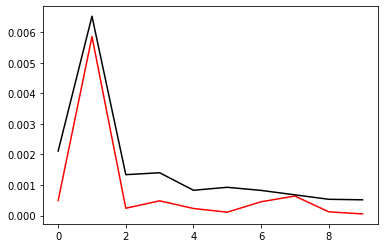

In [8]:
import collections
p2p = P2P_AFPL(total_clients,train_data,train_partition,test_data,test_partition)
alphas = p2p.loop(10,graph)

In [65]:
class calculate_SHAP(SHAP_kernel):
    def __init__(self,selected_clients,dataset,samples,p2p):
        super().__init__(len(selected_clients),samples,verbose=False)
        self.n_clients = len(selected_clients)
        self.samples = samples
        self.dataset = dataset
        self.selected_clients = selected_clients
        self.p2p = p2p 
        self.define_shap()
        
    def define_shap(self):
        # define Shap kernel
        #shap = SHAP_kernel(self.n_clients,self.samples,verbose=False)
        self.forward_shap()
        coalition_object = create_coalitions(self.adjusted,self.weights,self.n_clients)
        self.masks, self.weights = coalition_object.forward()
        self.masks = np.asarray(self.masks,dtype='bool')
        
    def combine_models(self,p2p,coalitions):
        shared_model = copy.deepcopy(p2p.network).double().cuda()
        n_clients = len(selected_clients)
        weight = [p2p.len[str(x)] for x in selected_clients]
        weight = weight / np.sum(weight)
        #print("weights ",weight)
        for idx,i in enumerate(coalitions): 
            for (name, param),(name2,param2) in zip(shared_model.named_parameters()
                                                      ,p2p.client_models[str(i)].named_parameters()):
                if idx == 0: 
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx]*param2.data 
        shared_model = shared_model.double()
        return shared_model
        
    def solve(self,ey,fnull,maskMatrix,M,fx,dim,kernelWeights):
        eyAdj = ey[:, dim] - fnull[dim]
        s = np.sum(maskMatrix, 1)
        # do feature selection if we have not well enumerated the space
        nonzero_inds = np.arange(M)
        # eliminate one variable with the constraint that all features sum to the output
        eyAdj2 = eyAdj - maskMatrix[:, nonzero_inds[-1]] * (
                    (fx[dim]) - (fnull[dim]))
        etmp = np.transpose(np.transpose(maskMatrix[:, nonzero_inds[:-1]]) - maskMatrix[:, nonzero_inds[-1]])
        # solve a weighted least squares equation to estimate phi
        tmp = np.transpose(np.transpose(etmp) * np.transpose(kernelWeights))
        #print("tmp ",np.shape(tmp))
        etmp_dot = np.dot(np.transpose(tmp), etmp)
        try:
            tmp2 = np.linalg.inv(etmp_dot)
        except np.linalg.LinAlgError:
            tmp2 = np.linalg.pinv(etmp_dot)
            warnings.warn(
                "Linear regression equation is singular, Moore-Penrose pseudoinverse is used instead of the regular inverse.\n"
                "To use regular inverse do one of the following:\n"
                "1) turn up the number of samples,\n"
                "2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,\n"
                "3) group features together to reduce the number of inputs that need to be explained."
            )
        w = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))
        phi = np.zeros(M)
        phi[nonzero_inds[:-1]] = w
        phi[nonzero_inds[-1]] = ((fx[dim]) - (fnull[dim])) - sum(w)
        # clean up any rounding errors
        for i in range(M):
            if np.abs(phi[i]) < 1e-10:
                phi[i] = 0
        return phi
    
    def calc_accuracy(self,model):
        
        for i in [10]: # we take subject 10 as test 
            dataloader = self.p2p.dataloaders_test[str(i)]
            intermediate_accuracy = 0 

            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target = target.long().cuda()
                output = model(data)
                output_array = output.detach().cpu().numpy()
                output_class = np.argmax(output_array,axis=-1)
                target_array = target.detach().cpu().numpy()
                intermediate_accuracy += np.sum(output_class == target_array)

            accuracy = intermediate_accuracy/p2p.len_test[str(i)]*100
            #print(i)
            #print(accuracy)
            return accuracy 
        
    def forward(self,index,evaluation="loss"):
        instance = self.dataset[index]
        
        # calculate ey, output for all coalitions 
        ey= np.zeros((len(self.masks),1))
        for i,coalition in enumerate(self.masks): 
            selected_clients_coalition = self.selected_clients[coalition]
            shared_model = self.combine_models(self.p2p,selected_clients_coalition)
            shared_model.eval().cuda()
            if evaluation == "loss":
                ey[i] = F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
            else: 
                ey[i] = self.calc_accuracy(shared_model)
        ey = np.reshape(ey,(len(ey),1))
        
        # calculate fnull, prediction without knowledge (empty initialized model)
        # we calculate the prediction of an untrained model 
        p2p.network.eval().cuda().double()
        if evaluation == "loss":
            fnull = F.nll_loss(p2p.network(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        else: 
            fnull = self.calc_accuracy(p2p.network)
        fnull = np.reshape(fnull,(1,1))
        #print("untrained model: ",fnull)
        self.fnull = fnull 

        # calculate fx 
        shared_model = self.combine_models(self.p2p,selected_clients)
        shared_model.eval().cuda()
        if evaluation == "loss": 
            fx = F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        else: 
            fx = self.calc_accuracy(shared_model)
        fx = np.reshape(fx,(1,1))
        #print(fx)
        self.fx = fx 
        
        masks = np.asarray(self.masks,dtype = 'int')
        phi = self.solve(ey,fnull,masks,len(self.selected_clients),fx,0,self.weights)
        return phi 
    
    def forward2(self,evaluation="loss"):
        #ey= np.zeros((len(self.masks),len(p2p.dataloaders_test[str(10)])))
        ey = np.zeros((len(self.masks),p2p.len_test[str(10)]))
        # calculate ey, output for all coalitions 

        for i,coalition in enumerate(self.masks): 
            selected_clients_coalition = self.selected_clients[coalition]
            shared_model = self.combine_models(self.p2p,selected_clients_coalition)
            shared_model.eval().cuda()
            for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
                data = data.double().cuda()
                target = target.long().cuda()

                ey[i,batch_idx*16:batch_idx*16+len(target)] = F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy()
                
        #print(ey)

        # calculate fnull, prediction without knowledge (empty initialized model)
        # we calculate the prediction of an untrained model 
        p2p.network.eval().cuda().double()
        #fnull = np.zeros((len(p2p.dataloaders_test[str(10)]),1))
        fnull = np.zeros((p2p.len_test[str(10)],1))
        for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
            data = data.double().cuda()
            target = target.long().cuda()
            fnull[batch_idx*16:batch_idx*16+len(target)] = np.reshape(F.nll_loss(p2p.network(data),target,reduction='none').detach().cpu().numpy(),(len(target),1))
        
        #print(fnull)
        #print("untrained model: ",fnull)

        # calculate fx 
        shared_model = self.combine_models(self.p2p,selected_clients)
        shared_model.eval().cuda()
        #fx = np.zeros((len(p2p.dataloaders_test[str(10)]),1))
        fx = np.zeros((p2p.len_test[str(10)],1))
        for batch_idx, (data, target) in enumerate(p2p.dataloaders_test[str(10)]):
            data = data.double().cuda()
            target = target.long().cuda()
            fx[batch_idx*16:batch_idx*16 + len(target)] = np.reshape(F.nll_loss(shared_model(data),target,reduction='none').detach().cpu().numpy(),(len(target),1))
        #print(fx)

        #masks = np.asarray(self.masks,dtype = 'int')
        #phi = self.solve(ey,fnull,masks,len(self.selected_clients),fx,0,self.weights)
        return ey, fnull, fx 
        
selected_clients = np.array([0,1,2,3,4,5,6,7,8,9])
samples = 200

phi_my_new = np.zeros((1,10))
for i in range(1):
    calc_shap = calculate_SHAP(selected_clients,p2p.dataloaders_test[str(10)],samples,p2p)

# calculate phi value for 100 random samples in the train dataset 
print(len(dataset_train))
#indices = np.random.randint(len(dataset_train),size=100)
#indices = [i for i in range(len(p2p.dataloaders_test[str(10)]))]
#phis = np.zeros((len(indices),len(selected_clients)))
#for idx,i in enumerate(indices): 
ey, fnull, fx = calc_shap.forward2()

#  phi_my_new[i,:] = calc_shap.forward(109) #,evaluation="acc")
#print(phi_my_new)
#print(phi_gt)
        

1583


In [28]:
# save the ey's and such 
np.savetxt("ey.txt",ey,fmt='%f')
np.savetxt("fnull.txt",fnull,fmt='%f')
np.savetxt("fx.txt",fx,fmt='%f')

In [8]:
ey = np.loadtxt("ey.txt",dtype=float)
fnull = np.loadtxt("fnull.txt",dtype=float)
fx = np.loadtxt("fx.txt",dtype=float)
print(np.shape(fx))

(838,)


(199, 385)
(385, 1)
(385, 1)
[10. 32. 25. 22. 21. 22. 25. 32. 10.]


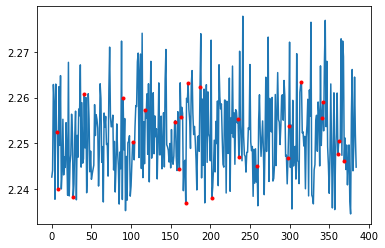

In [10]:
#assess if we can promote sparsity in other directions as well 
print(np.shape(ey))
print(np.shape(fnull))
print(np.shape(fx))
print(calc_shap.discrete_shap)

indices = np.random.randint(p2p.len_test[str(10)],size=25)

plt.plot(ey[42,:])
plt.plot(indices,ey[42,indices],'r.')


In [67]:
from time import time 
# calculate 'ground truth' SV based on only one sample 
selected_clients = np.array([0,1,2,3,4,5,6,7,8,9])

samples = 1022
calc_shap = calculate_SHAP(selected_clients,dataset_train,samples,p2p)
calc_shap2 = calculate_SHAP(selected_clients,dataset_train,200,p2p)
# calculate phi value for 100 random samples in the train dataset 
print(len(dataset_train))
indices = np.random.randint(385,size=25)

# do this for 10 clients: 
phis_single2 = np.zeros((25,10))
phis_single200 = np.zeros((25,10))
phis_single200b = np.zeros((25,10))
phis_single200c = np.zeros((25,10))
time1_store = 0 
time2_store = 0 
time3_store = 0 
time4_store = 0 
fnull_array = np.zeros(25)
fx_array = np.zeros(25)
for j,i in enumerate(indices): 
    print(j)
    phi_gt_single2 = calc_shap2.forward(i,evaluation="loss")
    fnull_array[j] = calc_shap2.fnull
    fx_array[j] = calc_shap2.fx
    phis_single200[j,:] = phi_gt_single2#/np.sum(phi_gt_single2)


1583
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


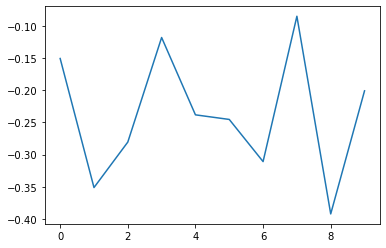

In [64]:
# Analize the SV based on loss (unnormalized)
plt.plot(np.mean(phis_single200,axis=0))
plt.plot()

In [21]:
from time import time 
# calculate 'ground truth' SV based on only one sample 
selected_clients = np.array([0,1,2,3,4,5,6,7,8,9])

samples = 1022
calc_shap = calculate_SHAP(selected_clients,dataset_train,samples,p2p)
calc_shap2 = calculate_SHAP(selected_clients,dataset_train,200,p2p)
# calculate phi value for 100 random samples in the train dataset 
print(len(dataset_train))
indices = np.random.randint(385,size=25)



# do this for 10 clients: 
phis_single = np.zeros((25,10))
phis_single200 = np.zeros((25,10))
phis_single200b = np.zeros((25,10))
phis_single200c = np.zeros((25,10))
time1_store = 0 
time2_store = 0 
time3_store = 0 
time4_store = 0 
for j,i in enumerate(indices): 
    print(j)
    time0 = time()
    phi_gt_single = calc_shap.forward(i,evaluation="loss")
    phis_single[j,:] = phi_gt_single/np.sum(phi_gt_single)
    time1 = time() - time0
    time01 = time()
    phi_gt_single2 = calc_shap2.forward(i,evaluation="loss")
    phis_single200[j,:] = phi_gt_single2/np.sum(phi_gt_single2)
    time2 = time() - time01
    time02 = time()
    calc_shap3 = calculate_SHAP(selected_clients,dataset_train,200,p2p)
    phi_gt_single3 = calc_shap3.forward(i,evaluation="loss")
    phis_single200b[j,:] = phi_gt_single3/np.sum(phi_gt_single3)
    time3 = time() - time02 
    time03 = time()
    calc_shap4 = calculate_SHAP(selected_clients,dataset_train,100,p2p)
    phi_gt_single4 = calc_shap4.forward(i,evaluation="loss")
    phis_single200c[j,:] = phi_gt_single4/np.sum(phi_gt_single4)
    time4 = time() - time03
    
    
    time1_store += time1 
    time2_store += time2 
    time3_store += time3 
    time4_store += time4

1583
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [55]:
print(time1_store)
print(time2_store)
print(time3_store)
print(time4_store)

70.92292380332947
13.934507369995117
14.011664390563965
7.035779714584351


In [16]:
#let's just extrapolate the times to all samples 
print(time1_store)
print(time2_store)
print(time3_store)

# and then compare it with the batch-based processing 
time0 = time()
ey, fnull, fx = calc_shap.forward2()
phici = np.zeros((p2p.len_test[str(10)],10))
masks = np.asarray(calc_shap.masks,dtype = 'int')
for batch in range(p2p.len_test[str(10)]):
    eyb = np.reshape(ey[:,batch],(len(ey[:,batch]),1))
    #ey = np.reshape(ey,(len(ey),1))
    phici[batch,:] = calc_shap.solve(eyb,fnull[batch],masks,10,fx[batch],0,calc_shap.weights)
    phici[batch,:] = phici[batch,:]/np.sum(phici[batch,:])
print(np.mean(phici,axis=0))
time1 = time()-time0
print(time1)

71.33281135559082
14.040536642074585
14.051563024520874
[0.11436479 0.09937975 0.09973376 0.0926047  0.0849392  0.09873409
 0.09810535 0.1044152  0.10760458 0.10011859]
42.64838767051697


0.023060354893002205
0.004019218744668084
0.007416849850409952
[0.00026757 0.00269492 0.00115262 0.00222433 0.00067572 0.00111994
 0.01077966 0.01607611 0.00175409 0.00344724]
0.016076108349058732
[0.01299353 0.00514128 0.01091538 0.00850043 0.01090568 0.00764436
 0.00039482 0.01253687 0.00138901 0.00374715]
0.012993528891572015


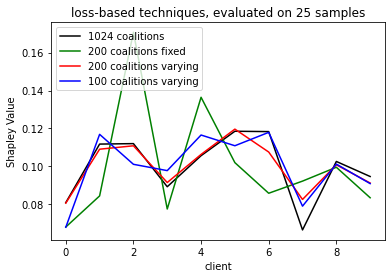

In [62]:
#plt.plot(0.2-phi_gt_normalized,'k')
plt.plot(np.mean(phis_single,axis=0),'k',label='1024 coalitions')
#plt.plot(np.mean(phici,axis=0),'b',label)
plt.plot(np.mean(phis_single200,axis=0),'g',label='200 coalitions fixed')
plt.plot(np.mean(phis_single200b,axis=0),'r',label='200 coalitions varying')
plt.plot(np.mean(phis_single200c,axis=0),'b',label='100 coalitions varying')
plt.xlabel("client")
plt.ylabel("Shapley Value")
plt.legend(loc="upper left")
plt.title("loss-based techniques, evaluated on 25 samples")
# we could also compare this with phici

# calculate MAE + MD 
error_1 = 0 
error_2 = 0 
error_3 = 0
MD_2 = np.zeros(10)
MD_3 = np.zeros(10)
i = 0 
for sv1, sv2,sv3,sv0 in zip(np.mean(phis_single200,axis=0),np.mean(phis_single200b,axis=0)
                            ,np.mean(phis_single200c,axis=0),np.mean(phis_single,axis=0)):
    
    error_1 += np.sum(np.abs(sv1 - sv0))
    error_2 += np.sum(np.abs(sv2 - sv0))
    error_3 += np.sum(np.abs(sv3 - sv0))
    MD_2[i] = np.sum(np.abs(sv2 - sv0))
    MD_3[i] = np.sum(np.abs(sv3-sv0))
    i = i + 1 
print(error_1/10)
print(error_2/10)
print(error_3/10)
print(MD_2)
print(np.max(MD_2))
print(MD_3)
print(np.max(MD_3))


In [49]:
# evaluate my own method 10 times 
phi_my = np.zeros((10,10))
for i in range(10):
    print(i)
    calc_shap2 = calculate_SHAP(selected_clients,dataset_train,200,p2p)
    phi_my[i,:] = calc_shap2.forward(109,evaluation="acc")
print(phi_my)

0
1
2
3
4
5
6
7
8
9
[[ 1.57147980e+01  5.41258867e+00  3.34411138e+00 -5.42057953e+00
   7.45425521e-01  4.36686390e+00  1.38506466e+00  5.95913129e+00
   7.86180976e+00  3.71046087e-01]
 [ 1.18682938e+01  3.00389229e+00  2.63183363e+00 -4.19819731e+00
   5.86739820e+00  3.71537582e+00  1.13953160e+00  7.36345204e+00
   9.16106612e+00 -8.12386459e-01]
 [ 9.98093636e+00  6.85653147e+00 -5.40223891e-01 -4.69555904e+00
   4.84145100e+00  5.46621547e+00  2.26606768e+00  1.37641570e+01
   4.90820992e+00 -3.10752622e+00]
 [ 1.33302690e+01  3.32553377e+00  1.47948409e+00  9.56752388e+00
  -5.08260512e+00 -9.92069679e-01  5.96817617e-01  8.84091294e+00
   8.08786846e+00  5.86524789e-01]
 [ 1.24688206e+01  4.71816804e+00  5.20165410e+00  2.27732880e+00
  -4.87388699e+00  2.83289202e+00 -4.15961635e+00  8.76475236e+00
   1.23880593e+01  1.22087842e-01]
 [ 1.46584341e+01  2.44809451e+00  2.79850148e+00  2.69421609e+00
  -5.94694829e+00  3.79109999e+00  2.31779413e+00  4.72301739e+00
   1.22452054

error GTG:  3.419456678332487
error mine:  2.4051228523993893


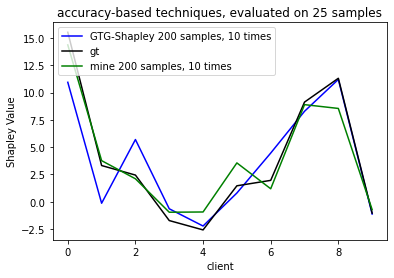

In [54]:
# accuracy-based techniques
plt.plot(np.mean(phi_gtg,axis=0),'b',label='GTG-Shapley 200 samples, 10 times')
plt.plot(phi_gt,'k',label='gt')
plt.plot(np.mean(phi_my,axis=0),'g',label='mine 200 samples, 10 times')

plt.xlabel("client")
plt.ylabel("Shapley Value")
plt.legend(loc="upper left")
plt.title("accuracy-based techniques, evaluated on 25 samples")
# we could also compare this with phici

# calculate MAE 
error_1 = 0 
error_2 = 0 

for sv1, sv2 in zip(phi_gtg,phi_my):
    error_1 += np.sum(np.abs(sv1 - phi_gt))
    error_2 += np.sum(np.abs(sv2 - phi_gt))

print('error GTG: ',error_1/100)
print('error mine: ',error_2/100)

(199, 838)
(199,)
[0.09206845 0.10089153 0.08575241 0.12324458 0.09916746 0.0857128
 0.11270297 0.12311465 0.08845608 0.08888908]
[0.09226683 0.10239356 0.08141787 0.12733703 0.0998993  0.08076487
 0.11814106 0.12796763 0.08343012 0.08638174]


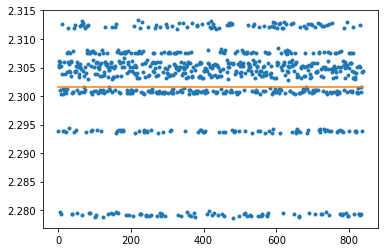

In [35]:
print(np.shape(ey))
dim=6
plt.plot(ey[dim,:],'.')
plt.plot(np.tile(np.mean(ey[dim,:]),len(ey[dim,:])))
mean_ey = np.mean(ey,axis=1)
print(np.shape(mean_ey))
mean_ey = np.reshape(mean_ey,(len(mean_ey),1))
mean_fx = np.mean(fx)
mean_fx = np.reshape(mean_fx,(1,1))
mean_fnull = np.mean(fnull)
mean_fnull= np.reshape(mean_fnull,(1,1))
masks = np.asarray(calc_shap.masks,dtype = 'int')
phi_avg = calc_shap.solve(mean_ey,mean_fnull,masks,10,mean_fx,0,calc_shap.weights)
print(phi_avg/np.sum(phi_avg))
### now we calculate the shap values separately: 
phici = np.zeros((p2p.len_test[str(10)],10))
masks = np.asarray(calc_shap.masks,dtype = 'int')
uniform_weights = np.tile(1/len(calc_shap.weights),len(calc_shap.weights)) 
for batch in range(p2p.len_test[str(10)]):
    eyb = np.reshape(ey[:,batch],(len(ey[:,batch]),1))
    #ey = np.reshape(ey,(len(ey),1))
    phici[batch,:] = calc_shap.solve(eyb,fnull[batch],masks,10,fx[batch],0,uniform_weights) #calc_shap.weights)
    phici[batch,:] = phici[batch,:]/np.sum(phici[batch,:])
print(np.mean(phici,axis=0))
#print(np.mean(phibi,axis=0))
#print(phi_gt_normalized)
# it is worse with uniform weights 

0.06389512415669062


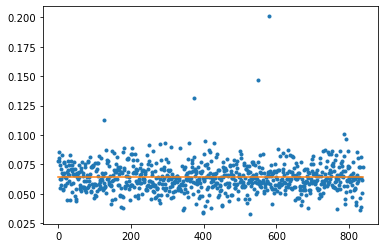

In [70]:
#print(np.shape(phibi))
dim = 8
print(np.mean(phibi[:,dim]))
# 3, 8
plt.plot(phibi[:,dim],'.')
plt.plot(np.tile(np.mean(phibi[:,dim]),len(phibi[:,dim])))

[[0.0195 0.     0.     ... 0.0195 0.0195 0.    ]
 [0.     0.0195 0.     ... 0.0195 0.     0.0195]
 [0.     0.     0.0195 ... 0.     0.0195 0.0195]
 ...
 [0.     0.     0.     ... 0.0195 0.0195 0.0195]
 [0.     0.     0.     ... 0.0195 0.0195 0.0195]
 [0.     0.     0.     ... 0.0195 0.0195 0.0195]]
[ 99 102  95 105 104  95  99  97 105  94]
[0.09830461 0.10819318 0.12379175 0.08837101 0.10476749 0.12441607
 0.08982162 0.10133629 0.06389512 0.09710286]
(199,)


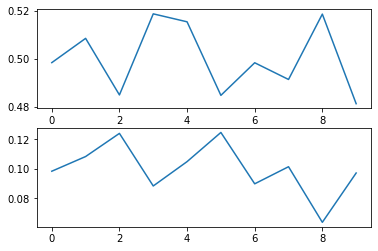

In [83]:
print(np.transpose(masks)*calc_shap.weights)
print(np.sum(masks,axis=0))
print(np.mean(phibi,axis=0))
print(np.shape(calc_shap.weights))
fig,[ax1,ax2] = plt.subplots(2,1)
ax1.plot(np.sum(np.transpose(masks)*calc_shap.weights,axis=1))
ax2.plot(np.mean(phibi,axis=0))

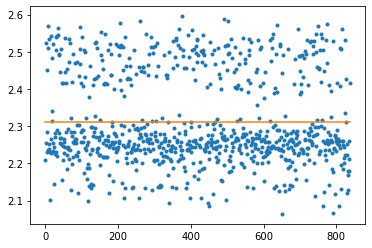

In [41]:
plt.plot(fnull,'.')
plt.plot(np.tile(np.mean(fnull),len(fnull)))

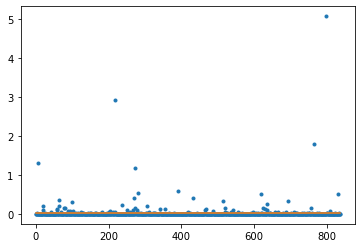

In [42]:
plt.plot(fx,'.')
plt.plot(np.tile(np.mean(fx),len(fx)))

In [10]:
### now we calculate the shap values separately: 
phibi = np.zeros((len(p2p.dataloaders_test[str(10)]),10))
masks = np.asarray(calc_shap.masks,dtype = 'int')
for batch in range(len(p2p.dataloaders_test[str(10)])):
    eyb = np.reshape(ey[:,batch],(len(ey[:,batch]),1))
    #ey = np.reshape(ey,(len(ey),1))
    phibi[batch,:] = calc_shap.solve(eyb,fnull[batch],masks,10,fx[batch],0,calc_shap.weights)
    phibi[batch,:] = phibi[batch,:]/np.sum(phibi[batch,:])
print(np.mean(phibi,axis=0))
#print(phi_gt_normalized)

NameError: name 'p2p' is not defined

(53, 10)


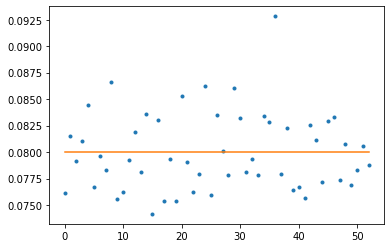

In [43]:
print(np.shape(phibi))
dim = 1 
plt.plot(phibi[:,dim],'.')
plt.plot(np.tile(np.mean(phibi[:,dim]),len(phibi[:,dim])))

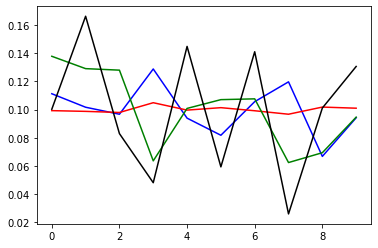

In [97]:
plt.plot(np.mean(phibi,axis=0),'b')
plt.plot(phi_gt_normalized,'r')
plt.plot(phi_my[1]/np.sum(phi_gt),'g')
plt.plot(phi_gtg[1]/np.sum(phi_gt),'k')
#plt.plot([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],'k')

In [ ]:
# calculate MSE 
error_1 = 0 
error_2 = 0 
for sv1, sv2 in zip(phi_gtg/np.sum(phi_gt),phi_my):
    error_1 += np.sum((sv1 - phi_gt_normalized)**2)
    error_2 += np.sum((sv2 - phi_gt_normalized)**2)
print(error_1/10)
print(error_2/10)

In [63]:
print(len(p2p.dataloaders_test[str(10)]))

53


In [62]:
phib = phis 
for i,row in enumerate(phib): 
    phib[i] = row / np.sum(row)
print(np.mean(phib,axis=0))
phi_gt_normalized =phi_gt/np.sum(phi_gt)
print(phi_gt_normalized)

[0.13271519 0.11644414 0.10169385 0.08824246 0.08899126 0.10297129
 0.10891918 0.10237798 0.05624802 0.10139663]
[0.09920788 0.09869487 0.09789585 0.10482556 0.0995911  0.10131608
 0.09912793 0.09666816 0.10173356 0.10093901]


In [55]:
# calculate GT: 
phis_gt = np.zeros((p2p.len_test[str(10)],10))

for i in range(p2p.len_test[str(10)]):
    phi_gt_single = calc_shap.forward(j,evaluation="loss")
    phis_gt[j,:] = phi_gt_single/np.sum(phi_gt_single)

In [53]:
print(time1_store)
print(time2_store)
print(time3_store)


69.65389394760132
13.679240942001343
13.705563068389893


In [37]:
# calculate 'ground truth' SV 
selected_clients = np.array([0,1,2,3,4,5,6,7,8,9])
#selected_clients = np.array([0,1,2,3,4,5,6,7,10,11])
samples = 1022
calc_shap = calculate_SHAP(selected_clients,dataset_train,samples,p2p)

# calculate phi value for 100 random samples in the train dataset 
print(len(dataset_train))
indices = np.random.randint(len(dataset_train),size=100)

#phis = np.zeros((len(indices),len(selected_clients)))
#for idx,i in enumerate(indices): 
#    phis[idx,:] = calc_shap.forward(i)
#print(np.mean(phis,axis=0))
phi_gt = calc_shap.forward(109,evaluation="acc")
print(phi_gt)

1583
[15.52272727  3.31189123  2.43628247 -1.72970779 -2.58705357  1.45515422
  1.95231331  9.12357955 11.30499188 -1.04991883]


In [73]:
phi_gt_normalized = phi_gt/np.sum(phi_gt)
print(phi_gt_normalized)
print(np.mean(phis_single,axis=0))

[0.12985983 0.09970088 0.10488943 0.09798951 0.06959935 0.07912989
 0.09509459 0.11917383 0.11362722 0.09093547]
[0.09274679 0.10621445 0.10947631 0.09346232 0.09975562 0.10986232
 0.11209641 0.08202654 0.0975963  0.09676296]


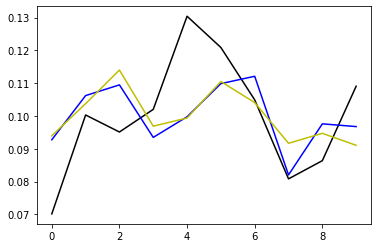

In [76]:
plt.plot(0.2-phi_gt_normalized,'k')
plt.plot(np.mean(phis_single,axis=0),'b')
#plt.plot(np.mean(phis_single200,axis=0),'g')
plt.plot(np.mean(phis_single200b,axis=0),'y')
# we could also compare this with phici

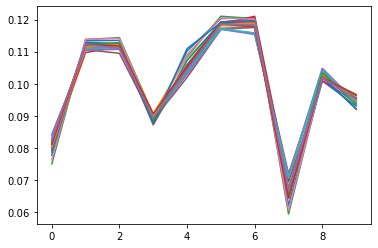

In [27]:
plt.plot(np.transpose(phis_single))

In [35]:
import itertools 
m = 2
#print(list(itertools.permutations(range(10),5)))
permutations = list(itertools.permutations(range(10),2))
print(len(permutations))
print(list(permutations[0]))

90
[0, 1]


In [13]:
# check if the properties are fulfilled properly: 
# Local accuracy 
print(calc_shap.fx)
print(calc_shapfnull)
check = fnull + np.sum(phis)
print(check)

AttributeError: 'calculate_SHAP' object has no attribute 'fx'

#### GTG-Shapley

In [56]:
import random 
import itertools
class GTG_SHAP(object):
    def __init__(self,selected_clients,dataset,p2p):
        self.n_clients = len(selected_clients)
        self.dataset = dataset
        self.selected_clients = selected_clients
        self.p2p = p2p 
        
    def combine_models(self,p2p,coalitions):
        shared_model = copy.deepcopy(p2p.network).double().cuda()
        n_clients = len(selected_clients)
        weight = [p2p.len[str(x)] for x in selected_clients]
        weight = weight / np.sum(weight)
        #print("weights ",weight)
        for idx,i in enumerate(coalitions): 
            for (name, param),(name2,param2) in zip(shared_model.named_parameters()
                                                      ,p2p.client_models[str(i)].named_parameters()):
                if idx == 0: 
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx]*param2.data 
        shared_model = shared_model.double()
        return shared_model
    
   # def check_convergence(self):

    def calc_accuracy(self,model):
        
        for i in [10]: # we take subject 10 as test 
            dataloader = self.p2p.dataloaders_test[str(i)]
            intermediate_accuracy = 0 

            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.double().cuda()
                target = target.long().cuda()
                output = model(data)
                output_array = output.detach().cpu().numpy()
                output_class = np.argmax(output_array,axis=-1)
                target_array = target.detach().cpu().numpy()
                intermediate_accuracy += np.sum(output_class == target_array)

            accuracy = intermediate_accuracy/p2p.len_test[str(i)]*100
            return accuracy 
        
    def forward(self,index,evaluation='loss'):
        instance = self.dataset[index]
        
        model_t_1 = self.combine_models(self.p2p,self.selected_clients)
        if evaluation == 'loss': 
            v_N = F.nll_loss(model_t_1(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
            v_0 = F.nll_loss(self.p2p.shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
        else: 
            v_N = self.calc_accuracy(model_t_1)
            v_0 = self.calc_accuracy(self.p2p.network.double().cuda()) #self.p2p.shared_model)
        
        v = np.zeros(len(self.selected_clients)+1)
        v[0] = v_0 
        phis = np.zeros(10) # initialize phi vector
        print('v_N',v_N)
        print("v_0",v_0)
        
        skipped = 0 
        evaluations = 0 
        k = 0 
        permutations = list(itertools.permutations(range(10),1))
        #for k in range(1,40): # change this to while loop later
        while evaluations <= 200: 
            k = k + 1 
            #sel_clients = list(self.selected_clients)
            #sorted_clients = list(np.argsort(phis)[0])
            #random.shuffle(sel_clients)
        
            fixed_permutation = list(permutations[k % len(permutations)])
            #print(fixed_permutation)
            rest = [i for i in self.selected_clients if i not in fixed_permutation]
            #print(rest)
            random.shuffle(rest)
            #print(rest)
            sel_clients = fixed_permutation + rest 



            #print(sel_clients) # partial permutation of samples is of length n, it's just that the first clients are sorted according to the SV 
            # take permutation of participants # let's set it to half of the clients. 
            #print('k',k)
            for j in range(1,len(sel_clients)+1): # n 
                if np.abs(v_N - v[j-1]) >= 0.005:
                    shared_model = self.combine_models(self.p2p,np.array(sel_clients[:j]))
                    if evaluation == 'loss': 
                        v[j] = F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
                    else: 
                        v[j] = self.calc_accuracy(shared_model)
                    evaluations += 1 
                else: 
                    v[j] = v[j-1]
                    skipped += 1 

                phis[sel_clients[j-1]] = (k-1)/k * phis[sel_clients[j-1]] + 1/k * (v[j]-v[j-1])
                #print(v[j])
            #print(phis)
            #reak 
        print(skipped)
        print(k)
        return phis,skipped
        
selected_clients = np.array([0,1,2,3,4,5,6,7,8,9])
samples = 14 
gtg_shap = GTG_SHAP(selected_clients,dataset_train,p2p)
#phi_gtg = np.zeros((10,10))
for i in range(10):
    time0 = time()
    print(i)
    phip,skipped = gtg_shap.forward(109,evaluation="acc")
    #phi_gtg[i,:] = phip
    print(skipped)
    time1 = time() - time0 
    break
print(phi_gtg)



0
v_N 96.1038961038961
v_0 56.36363636363636
1
21
1
[[ 8.17563389  2.07792208  7.21088435 -2.35003092 -4.15584416  0.14842301
   2.84477427 11.02040816 17.10575139 -5.31849103]
 [ 8.65800866  9.26406926 -0.42053185  0.25974026 -4.21768707  4.55163884
   0.22263451 10.04329004  7.66852195  1.31106988]
 [ 7.32220161 -4.29189858 11.03277675 -3.31478046 -2.48608534  1.81818182
  -1.66975881 13.84044527 13.90228819  1.34817563]
 [15.89363018  0.50711194  3.04267161  3.32714904 -5.15769944 -3.00556586
   4.26716141  6.87693259 12.38095238 -0.86580087]
 [ 8.59616574 -2.73345702  9.73407545  0.74211503 -1.3729128   0.16079159
  11.20593692  4.48979592  8.31168831 -1.97897341]
 [ 2.95609153  6.49350649  5.04638219  0.86580087 -1.03896104 10.84724799
   4.51453309  6.03586889  5.10822511 -3.30241187]
 [11.23966942  2.6918536   3.10507674 -0.6257379  -2.62101535  2.52656434
   4.62809917  5.2892562  15.51357733 -4.74616293]
 [13.98886827 -5.8750773  -0.68027211 -0.39579468 -1.92949907 -0.17316017

In [57]:
print(time1)

9.223571538925171


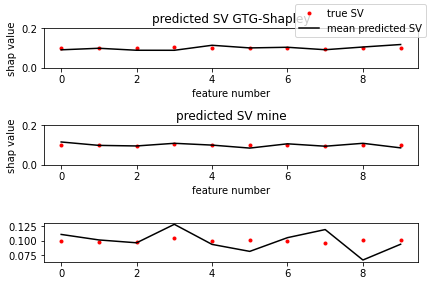

In [87]:
n_dim = 10
fig, (ax1,ax2,ax3) = plt.subplots(3,1)
ax1.plot(phi_gt/np.sum(ddd),".r",label="true SV")
ax2.plot(phi_gt/np.sum(ddd),".r")
ax3.plot(phi_gt/np.sum(ddd),".r")
ax1.plot(np.mean(phi_gtg/np.sum(ddd),axis=0),color='k',label="mean predicted SV")
ax2.plot(np.mean(phi_my/np.sum(ddd),axis=0),color='k')
ax3.plot(np.mean(phibi,axis=0),color='k')
#ax1.fill_between(np.arange(n_dim),np.mean(phi_gtg,axis=0)- np.std(phi_gtg,axis=0),
#                 np.mean(phi_gtg,axis=0)+ np.std(phi_gtg,axis=0),
 #               color='gray',alpha=0.5,label="std predicted SV")
#ax2.fill_between(np.arange(n_dim),np.mean(phi_my,axis=0) - np.std(phi_my,axis=0),
#                 np.mean(phi_my,axis=0)+ np.std(phi_my,axis=0),
 #               color='gray',alpha=0.5)
ax1.title.set_text("predicted SV GTG-Shapley")
ax2.title.set_text("predicted SV mine")
ax1.set_xlabel("feature number")
ax2.set_xlabel("feature number")
ax1.set_ylabel("shap value")
#ax1.set_ylim([0,20])
#ax2.set_ylim([0,20])
ax1.set_ylim([0 ,0.2])
ax2.set_ylim([0, 0.2])
ax2.set_ylabel("shap value")
plt.tight_layout()
fig.legend(loc='upper right')

In [43]:
# calculate MSE 
error_1 = 0 
error_2 = 0 
for sv1, sv2 in zip(phi_gtg,phi_my):
    error_1 += np.sum((sv1 - phi_gt)**2)
    error_2 += np.sum((sv2 - phi_gt)**2)
print(error_1)
print(error_2)

1317.078012537972
1223.6168484605812


In [49]:
ddd = phi_my[3]
print(ddd)
print(np.sum(ddd))
print(ddd/np.sum(ddd))


[15.92740512  4.87999102  3.49769129 11.17669799 10.03398611  9.54268235
 10.35582574 10.18967997 12.82222605  3.57858762]
92.00477326968974
[0.17311499 0.05304063 0.03801641 0.12147955 0.10905941 0.10371943
 0.11255748 0.11075164 0.13936479 0.03889567]


#### Calculate exact Shap values 

In [109]:
selected_clients = np.array([0,2,5,6])
masks = np.asarray(masks,dtype = 'bool')
for i,coalition in enumerate(masks): 
    print(selected_clients[coalition])
    

[0]
[2]
[5]
[6]
[0 2]
[0 5]
[0 6]
[2 5]
[2 6]
[5 6]
[0 2 5]
[0 2 6]
[0 5 6]
[2 5 6]


### Old code

In [130]:
# Do kernel method but then with losses and not with outputs, for the same sample as before 

# Compare Kernel method to GTG-Shapley method for FedAvg 
# we first assess the contribution to the global model in a FedAvg context (same as GTG-Shapley)
selected_clients = np.array([0,2,5,6])

# We collect all possible coalitions for 4 clients in masks, and give them the weight in weights. 
# For 4 clients this is the optimal scenario. 
n_clients = 4
shap = SHAP_kernel(n_clients,14,verbose=False)
shap.forward()
discrete_shap = shap.adjusted
coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
masks,weights = coalition_object.forward()
masks = np.asarray(masks,dtype = 'bool')

# We now take only one instance that we're trying to explain for simplicity and implement the Kernel method
iii = 2
instance = dataset_train[iii]#test_data[0][0]
#print(instance[0].shape)
#print(instance[1])
# show this instance 
#plt.imshow(instance[0][0,:,:].detach().numpy())
dim = 10 

ey= np.zeros((len(masks),1))

for i,coalition in enumerate(masks): 
    selected_clients_coalition = selected_clients[coalition]
    shared_model = federated_averaging(selected_clients_coalition)
    shared_model.eval().cuda()
    ey[i] = F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
# average over all dataloaders
#print(ey)
ey = np.reshape(ey,(len(ey),1))
#print(ey)

# calculate fnull 
# we calculate the average prediction 
#avg_output = average_prediction(dataloader)
#avg_output = torch.tensor(avg_output).double().cuda()
#avg_loss = average_loss(dataloader,avg_output)
#fnull = avg_loss.detach().cpu().numpy()
#fnull = np.reshape(fnull,(1,1))
#print("average loss: ",fnull)

# we calculate the prediction of an untrained model 
p2p.network.eval().cuda().double()
fnull = F.nll_loss(p2p.network(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
fnull = np.reshape(fnull,(1,1))
#print("untrained model: ",fnull)

# calculate fx 
shared_model = federated_averaging(selected_clients)
shared_model.eval().cuda()
fx = F.nll_loss(shared_model(instance[0].cuda()),instance[1].long().cuda().unsqueeze(0)).detach().cpu().numpy()
fx = np.reshape(fx,(1,1))
#print(fx)

masks = np.asarray(masks,dtype = 'int')
phi = solve(ey,fnull,masks,4,fx,0,weights)
print(phi[0])

[-0.57722272  0.05594191  0.48174556 -0.49867022]


/tmp/ipykernel_1999326/2884270689.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [102]:
def federated_averaging(selected_clients):
    shared_model = copy.deepcopy(p2p.network).double().cuda()
    n_clients = len(selected_clients)
    weight = [p2p.len[str(x)] for x in selected_clients]
    weight = weight / np.sum(weight)
    #print("weights ",weight)
    for idx,i in enumerate(selected_clients): 
        for (name, param),(name2,param2) in zip(shared_model.named_parameters()
                                                  ,p2p.client_models[str(i)].named_parameters()):
            if idx == 0: 
                param.data = torch.zeros(param.shape).cuda().double()
            param.data += weight[idx]*param2.data 

    shared_model = shared_model.double()
    return shared_model

def average_prediction(dataloader):
    p2p.shared_model.eval()
    loss_test = 0 
    loss_global = 0 
    avg_outputs = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data = data.double().cuda()
            target=target.long().cuda()
#
            output = p2p.shared_model(data)
    
            avg_outputs.append(torch.mean(output,0).detach().cpu().numpy())
    #print(output[0])
    #print(torch.mean(output,0).detach().cpu().numpy())
    return np.mean(np.array(avg_outputs),axis=0)

# Compare Kernel method to GTG-Shapley method for FedAvg 
# we first assess the contribution to the global model in a FedAvg context (same as GTG-Shapley)
selected_clients = np.array([0,2,5,6])

# We collect all possible coalitions for 4 clients in masks, and give them the weight in weights. 
# For 4 clients this is the optimal scenario. 
n_clients = 4
shap = SHAP_kernel(n_clients,14,verbose=False)
shap.forward()
discrete_shap = shap.adjusted
coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
masks,weights = coalition_object.forward()
masks = np.asarray(masks,dtype = 'bool')

# We now take only one instance that we're trying to explain for simplicity and implement the Kernel method
instance = dataset_train[9]#test_data[0][0]
print(instance[0].shape)
print(instance[1])
# show this instance 
#plt.imshow(instance[0][0,:,:].detach().numpy())

dim = 10 

# calculate ey 
ey = np.zeros((len(masks),dim))
weights2 = []
for i,coalition in enumerate(masks): 
    #print(coalition)
    selected_clients_coalition = selected_clients[coalition]
    shared_model = federated_averaging(selected_clients_coalition)
    shared_model.eval()
    ey[i,:] = shared_model(instance[0].cuda()).detach().cpu().numpy()
#print(ey)
    
# calculate fnull 
avg_outputs = np.zeros((len(selected_clients),dim))
for idx,i in enumerate(selected_clients): 
    dataloader = p2p.dataloaders_test[str(i)] 
    avg_outputs[idx,:] = average_prediction(dataloader)
fnull = np.mean(avg_outputs,axis=0)
#print(np.mean(avg_outputs,axis=0))

# calculate fx 
fx = p2p.shared_model(instance[0].cuda()).detach().cpu().numpy().T
#print(output)

masks = np.asarray(masks,dtype = 'int')
phi = solve(ey,fnull,masks,4,fx,8,weights)
print(phi[0])

torch.Size([1, 28, 28])
tensor(8., dtype=torch.float64)


/tmp/ipykernel_1999326/2884270689.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[1.3450524  2.7714671  2.72519644 2.71235555]


In [95]:
# check if the properties are fulfilled properly: 
# Local accuracy 
print(fx)
print(fnull)
check = fnull + np.sum(phi[0])
print(check)

[5.35246717]
[[737.86491582]]
[[5.35246717]]


In [91]:
# check if the properties are fulfilled properly: 
# Local accuracy 
print(fx[8])
print(fnull[8])
check = fnull[8] + np.sum(phi[0])
print(check)

[-0.00691327]
-9.515945662637344
-0.006913266949949204


In [89]:
def solve(ey,fnull,maskMatrix,M,fx,dim,kernelWeights):
        #print("ey: ",np.shape(self.ey))
        #print(self.ey)
        eyAdj = ey[:, dim] - fnull[dim]
        
        s = np.sum(maskMatrix, 1)
        #print("maskmatrix",np.shape(self.maskMatrix))
        #print("eyAdj",np.shape(eyAdj))
       # print(eyAdj)

        # do feature selection if we have not well enumerated the space
        nonzero_inds = np.arange(M)

        # eliminate one variable with the constraint that all features sum to the output
        eyAdj2 = eyAdj - maskMatrix[:, nonzero_inds[-1]] * (
                    (fx[dim]) - (fnull[dim]))
      #  print(eyAdj2)
        etmp = np.transpose(np.transpose(maskMatrix[:, nonzero_inds[:-1]]) - maskMatrix[:, nonzero_inds[-1]])
        #print("etmp ",np.shape(etmp))
        #print(etmp)
        
        # solve a weighted least squares equation to estimate phi
        tmp = np.transpose(np.transpose(etmp) * np.transpose(kernelWeights))
        #print("tmp ",np.shape(tmp))
        etmp_dot = np.dot(np.transpose(tmp), etmp)
        try:
            tmp2 = np.linalg.inv(etmp_dot)
        except np.linalg.LinAlgError:
            tmp2 = np.linalg.pinv(etmp_dot)
            warnings.warn(
                "Linear regression equation is singular, Moore-Penrose pseudoinverse is used instead of the regular inverse.\n"
                "To use regular inverse do one of the following:\n"
                "1) turn up the number of samples,\n"
                "2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,\n"
                "3) group features together to reduce the number of inputs that need to be explained."
            )
        w = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))

        phi = np.zeros(M)
        phi[nonzero_inds[:-1]] = w
        phi[nonzero_inds[-1]] = ((fx[dim]) - (fnull[dim])) - sum(w)

        # clean up any rounding errors
        for i in range(M):
            if np.abs(phi[i]) < 1e-10:
                phi[i] = 0

        return phi, np.ones(len(phi)) 

In [78]:
import copy
from typing import Callable

import numpy as np

class GTGShapleyValue(ShapleyValue):
    def __init__(self, worker_number: int, last_round_metric: float = 0):
        super().__init__(
            worker_number=worker_number, last_round_metric=last_round_metric
        )
        self.shapley_values: dict = {}
        self.shapley_values_S: dict = {}

        self.eps = 0.001
        self.round_trunc_threshold = 0.001

        self.converge_min = max(30, self.worker_number)
        self.last_k = 10
        self.converge_criteria = 0.05
        self.metric_fun: None | Callable = None
        self.save_fun: None | Callable = None

        self.max_percentage = 0.8
        self.max_number = min(
            2**self.worker_number,
            max(
                self.converge_min,
                self.max_percentage * (2**self.worker_number)
                + np.random.randint(-5, +5),
            ),
        )
        #get_logger().info("max_number %s", self.max_number)

    def compute(self):
        assert self.metric_fun is not None
        self.round_number += 1
        this_round_metric = self.metric_fun(
            self.round_number, set(range(self.worker_number))
        )
        if this_round_metric is None:
            #get_logger().warning("force stop")
            return
        if (
            abs(self.last_round_metric - this_round_metric)
            <= self.round_trunc_threshold
        ):
            self.shapley_values[self.round_number] = {
                i: 0 for i in range(self.worker_number)
            }
            self.shapley_values_S[self.round_number] = {
                i: 0 for i in range(self.worker_number)
            }
            if self.save_fun is not None:
                self.save_fun(
                    self.round_number,
                    self.shapley_values[self.round_number],
                    self.shapley_values_S[self.round_number],
                )
            #get_logger().info(
            #    "skip round %s, this_round_metric %s last_round_metric %s round_trunc_threshold %s",
            #    self.round_number,
            #    this_round_metric,
             #   self.last_round_metric,
             #   self.round_trunc_threshold,
            #)
            self.last_round_metric = this_round_metric
            return
        metrics = dict()

        # for best_S
        perm_records = dict()

        index = 0
        contribution_records: list = []
        while self.not_convergent(index, contribution_records):
            for worker_id in range(self.worker_number):
                index += 1
                v: list = [0] * (self.worker_number + 1)
                v[0] = self.last_round_metric
                marginal_contribution = [0 for i in range(self.worker_number)]
                perturbed_indices = np.concatenate(
                    (
                        np.array([worker_id]),
                        np.random.permutation(
                            [i for i in range(self.worker_number) if i != worker_id]
                        ),
                    )
                ).astype(int)

                for j in range(1, self.worker_number + 1):
                    subset = tuple(sorted(perturbed_indices[:j].tolist()))
                    # truncation
                    if abs(this_round_metric - v[j - 1]) >= self.eps:
                        if subset not in metrics:
                            if not subset:
                                metric = self.last_round_metric
                            else:
                                metric = self.metric_fun(self.round_number, subset)
                                if metric is None:
                                    #get_logger().warning("force stop")
                                    return
                            get_logger().info(
                                "round %s subset %s metric %s",
                                self.round_number,
                                 subset,
                                metric,
                            )
                            metrics[subset] = metric
                        v[j] = metrics[subset]
                    else:
                        v[j] = v[j - 1]

                    # update SV
                    marginal_contribution[perturbed_indices[j - 1]] = v[j] - v[j - 1]
                contribution_records.append(marginal_contribution)
                # for best_S
                perm_records[tuple(perturbed_indices.tolist())] = marginal_contribution

        # for best_S
        subset_rank = sorted(
            metrics.items(), key=lambda x: (x[1], -len(x[0])), reverse=True
        )
        best_S: tuple = None
        if subset_rank[0][0]:
            best_S = subset_rank[0][0]
        else:
            best_S = subset_rank[1][0]

        contrib_S = [
            v for k, v in perm_records.items() if set(k[: len(best_S)]) == set(best_S)
        ]
        SV_calc_temp = np.sum(contrib_S, 0) / len(contrib_S)
        round_marginal_gain_S = metrics[best_S] - self.last_round_metric
        round_SV_S: dict = dict()
        for client_id in best_S:
            round_SV_S[client_id] = float(SV_calc_temp[client_id])

        self.shapley_values_S[
            self.round_number
        ] = ShapleyValue.normalize_shapley_values(round_SV_S, round_marginal_gain_S)

        # calculating fullset SV
        # shapley value calculation
        if set(best_S) == set(range(self.worker_number)):
            self.shapley_values[self.round_number] = copy.deepcopy(
                self.shapley_values_S[self.round_number]
            )
        else:
            round_shapley_values = np.sum(contribution_records, 0) / len(
                contribution_records
            )
            assert len(round_shapley_values) == self.worker_number

            round_marginal_gain = this_round_metric - self.last_round_metric
            round_shapley_value_dict = dict()
            for idx, value in enumerate(round_shapley_values):
                round_shapley_value_dict[idx] = float(value)

            self.shapley_values[
                self.round_number
            ] = ShapleyValue.normalize_shapley_values(
                round_shapley_value_dict, round_marginal_gain
            )

        if self.save_fun is not None:
            self.save_fun(
                self.round_number,
                self.shapley_values[self.round_number],
                self.shapley_values_S[self.round_number],
            )
        get_logger().info("shapley_value %s", self.shapley_values[self.round_number])
        get_logger().info(
            "shapley_value_S %s", self.shapley_values_S[self.round_number]
        )
        self.last_round_metric = this_round_metric

    def not_convergent(self, index, contribution_records):
        if index >= self.max_number:
            get_logger().info("convergent for max_number %s", self.max_number)
            return False
        if index <= self.converge_min:
            return True
        all_vals = (
            np.cumsum(contribution_records, 0)
            / np.reshape(np.arange(1, len(contribution_records) + 1), (-1, 1))
        )[-self.last_k:]
        errors = np.mean(
            np.abs(all_vals[-self.last_k:] - all_vals[-1:])
            / (np.abs(all_vals[-1:]) + 1e-12),
            -1,
        )
        if np.max(errors) > self.converge_criteria:
            return True
        get_logger().info(
            "convergent for index %s and converge_min %s max error %s converge_criteria %s",
            index,
            self.converge_min,
            np.max(errors),
            self.converge_criteria,
        )
        return False

In [80]:
gtg_shap = GTGShapleyValue(worker_number=0,last_round_metric = 0.9)

    
gtg_shap.set_metric_function()
#output = gtg_shap.compute()

AssertionError: 

In [104]:
# Do kernel method but then with losses and not with outputs, and for the whole test set. 

# calculate ey 
def eval_coalition(shared_model,dataloader,calc_accuracy=False):
    shared_model.eval()
    loss_test = 0 
    loss_global = 0 
    intermediate_accuracy = 0 
    n_samples = 0 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data = data.double().cuda()
            target=target.long().cuda()

            outputg = shared_model(data)
            loss_global += F.nll_loss(outputg,target)
            output_array = outputg.detach().cpu().numpy()
            output_class = np.argmax(output_array,axis=-1)
            target_array = target.detach().cpu().numpy()
            intermediate_accuracy += np.sum(output_class == target_array)
            n_samples += len(target)

    accuracy = intermediate_accuracy/n_samples*100
    return accuracy

# Compare Kernel method to GTG-Shapley method for FedAvg 
# we first assess the contribution to the global model in a FedAvg context (same as GTG-Shapley)
selected_clients = np.array([0,2,5,6])

# We collect all possible coalitions for 4 clients in masks, and give them the weight in weights. 
# For 4 clients this is the optimal scenario. 
n_clients = 4
shap = SHAP_kernel(n_clients,14,verbose=False)
shap.forward()
discrete_shap = shap.adjusted
coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
masks,weights = coalition_object.forward()
masks = np.asarray(masks,dtype = 'bool')

# We now take only one instance that we're trying to explain for simplicity and implement the Kernel method
instance = dataset_train[9]#test_data[0][0]
print(instance[0].shape)
print(instance[1])
# show this instance 
#plt.imshow(instance[0][0,:,:].detach().numpy())
dim = 10 

# calculate ey 
#def eval_coalition(shared_model,dataloader):
 ##   shared_model.eval()
  #  loss_test = 0 
  #  loss_global = 0 
 #   with torch.no_grad():
      #  for batch_idx, (data, target) in enumerate(dataloader):
  #          data = data.double().cuda()
      #      target=target.long().cuda()
#
     #       outputg = shared_model(data)
     #       loss_global += F.nll_loss(outputg,target)
  #  return loss_global 

ey_first = np.zeros((len(selected_clients),len(masks)))
for ii,client in enumerate(selected_clients): 
    dataloader = p2p.dataloaders_test[str(client)]
    for i,coalition in enumerate(masks): 
        selected_clients_coalition = selected_clients[coalition]
        weight = (math.factorial(np.sum(coalition))*math.factorial(len(selected_clients)-np.sum(coalition)-1))/(math.factorial(len(selected_clients)))
        shared_model = federated_averaging(selected_clients_coalition)
        ey_first[ii,i] = eval_coalition(shared_model,dataloader)
# average over all dataloaders
ey = np.mean(ey_first,axis=0)
print(ey)
ey = np.reshape(ey,(len(ey),1))
#print(ey)
    
# calculate fnull 
# we calculate the average prediction 
avg_output = average_prediction(dataloader)
avg_output = torch.tensor(avg_output).double().cuda()
#print('average output: ',avg_output)
avg_loss = average_loss(dataloader,avg_output)
print(avg_loss)
fnull = np.array(10) #avg_loss.detach().cpu().numpy()
fnull = np.reshape(fnull,(1,1))

# calculate fx 
ey_first = np.zeros((len(selected_clients),1))
for ii,client in enumerate(selected_clients): 
    dataloader = p2p.dataloaders_test[str(client)]
    shared_model = federated_averaging(selected_clients)
    ey_first[ii] = eval_coalition(shared_model,dataloader) #.detach().cpu().numpy()
# average over all dataloaders
fx = np.mean(ey_first,axis=0)
print(fx)

masks = np.asarray(masks,dtype = 'int')
phi = solve(ey,fnull,masks,4,fx,0,weights)
print(phi[0])

torch.Size([1, 28, 28])
tensor(8., dtype=torch.float64)


/tmp/ipykernel_1999326/2884270689.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[ 9.63645418 97.73406375 97.43525896 97.41035857 96.937251   96.56374502
 96.14043825 97.75896414 97.53486056 97.58466135 97.70916335 97.43525896
 97.28585657 97.70916335]
tensor(737.7133, device='cuda:0', dtype=torch.float64)
[97.55976096]
[ 0.05675667 29.37264529 29.17019422 28.96016478]


In [27]:
import math 

def average_prediction(dataloader):
    p2p.shared_model.eval()
    loss_test = 0 
    loss_global = 0 
    avg_outputs = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data = data.double().cuda()
            target=target.long().cuda()
#
            output = p2p.shared_model(data)
    
            avg_outputs.append(torch.mean(output,0).detach().cpu().numpy())
    #print(output[0])
    #print(torch.mean(output,0).detach().cpu().numpy())
    return np.mean(np.array(avg_outputs),axis=0)

def average_loss(dataloader,avg_output):
    #p2p.shared_model.eval()
    loss_test = 0 
    loss_global = 0 
    avg_outputs = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data = data.double().cuda()
            target=target.long().cuda()

            loss_test += F.nll_loss(avg_output.unsqueeze(0).repeat(len(target),1),target)

    return loss_test

def federated_averaging(selected_clients):
    shared_model = copy.deepcopy(p2p.network).double().cuda()
    n_clients = len(selected_clients)
    weight = [p2p.len[str(x)] for x in selected_clients]
    weight = weight / np.sum(weight)
    #print("weights ",weight)
    for idx,i in enumerate(selected_clients): 
        for (name, param),(name2,param2) in zip(shared_model.named_parameters()
                                                  ,p2p.client_models[str(i)].named_parameters()):
            if idx == 0: 
                param.data = torch.zeros(param.shape).cuda().double()
            param.data += weight[idx]*param2.data 

    shared_model = shared_model.double()
    return shared_model

def eval_coalition(shared_model,dataloader,client):
    shared_model.eval()
    loss_test = 0 
    loss_global = 0 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data = data.double().cuda()
            target=target.long().cuda()
#
            output = p2p.client_models[str(client)](data)
            outputg = shared_model(data)
            loss_test += F.nll_loss(output,target)
            loss_global += F.nll_loss(outputg,target)
    return loss_test, loss_global 

# Compare Kernel method to GTG-Shapley method for FedAvg 
# we first assess the contribution to the global model in a FedAvg context (same as GTG-Shapley)
selected_clients = np.array([1,2,5,6])

# We collect all possible coalitions for 4 clients in masks, and give them the weight in weights. 
# For 4 clients this is the optimal scenario. 
n_clients = 4
shap = SHAP_kernel(n_clients,14,verbose=False)
shap.forward()
discrete_shap = shap.adjusted
coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
masks,weights = coalition_object.forward()
masks = np.asarray(masks,dtype = 'bool')

# Now we just check the clients one by one. 
# For the first client, what other clients can they best collaborate with? 
for client in selected_clients: 
    dataloader = p2p.dataloaders_test[str(client)]

    ey = []
    weights2 = []
    for i,coalition in enumerate(masks): 
        selected_clients_coalition = selected_clients[coalition]
        weight = (math.factorial(np.sum(coalition))*math.factorial(len(selected_clients)-np.sum(coalition)-1))/(math.factorial(len(selected_clients)))

        if client in selected_clients_coalition: # only take the coalitions with the relevant client  
            weights2.append(weight)
            #print(selected_clients_coalition)
            shared_model = federated_averaging(selected_clients_coalition)
            loss_test, loss_global = eval_coalition(shared_model,dataloader,client)
            # Find the same coalition but then without this client 
            coalition_without_1 = [x for x in selected_clients_coalition if x != client]
            if len(coalition_without_1) >= 1: 
                shared_model_no_1 = federated_averaging(coalition_without_1)
                _, loss_global2 = eval_coalition(shared_model_no_1,dataloader,client)
                #print("value of coalition without 1")
                #print(loss_global-loss_global2)
                ey.append((loss_global-loss_global2).detach().cpu().numpy())
            else: 
                # we calculate the average prediction 
                avg_output = average_prediction(dataloader)
                avg_output = torch.tensor(avg_output).double().cuda()
                #print('average output: ',avg_output)
                avg_loss = average_loss(dataloader,avg_output)

                #print('average loss: ',avg_loss)
                #print(loss_global - avg_loss)
                ey.append((loss_global-avg_loss).detach().cpu().numpy())

    #print(weights2) 
    ey = np.array(ey)
    ey2 = ey * weights2 
    #print(ey2)
    print("phi = ",np.sum(ey2))

/tmp/ipykernel_1999326/2884270689.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


phi =  -58.31346843052492
phi =  -60.167816886390696
phi =  -63.162126964136384
phi =  -62.44332680220646


In [90]:

# Compare Kernel method to GTG-Shapley method for FedAvg 
# we first assess the contribution to the global model in a FedAvg context (same as GTG-Shapley)
selected_clients = np.array([1,2,5,6])

# We collect all possible coalitions for 4 clients in masks, and give them the weight in weights. 
# For 4 clients this is the optimal scenario. 
n_clients = 4
shap = SHAP_kernel(n_clients,14,verbose=False)
shap.forward()
discrete_shap = shap.adjusted
coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
masks,weights = coalition_object.forward()
masks = np.asarray(masks,dtype = 'bool')

# Now we just check the clients one by one. 
# For the first client, what other clients can they best collaborate with? 
dataloader = p2p.dataloaders_test[str(1)]

ey = []

for i,coalition in enumerate(masks): 
    selected_clients_coalition = selected_clients[coalition]
    weight = weights[i]
    if 1 in selected_clients_coalition: # only take the coalitions with the relevant client  
        print(selected_clients_coalition)
        shared_model = federated_averaging(selected_clients_coalition)
        loss_test, loss_global = eval_coalition(shared_model,dataloader,1)
        print(loss_test,loss_global)

[1]
tensor(8.5740, device='cuda:0', dtype=torch.float64) tensor(8.5740, device='cuda:0', dtype=torch.float64)
[1 2]


/local/tmp.838797/ipykernel_1678900/2884270689.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor(8.4854, device='cuda:0', dtype=torch.float64) tensor(7.6966, device='cuda:0', dtype=torch.float64)
[1 5]
tensor(8.4718, device='cuda:0', dtype=torch.float64) tensor(7.5977, device='cuda:0', dtype=torch.float64)
[1 6]
tensor(8.4721, device='cuda:0', dtype=torch.float64) tensor(8.2552, device='cuda:0', dtype=torch.float64)
[1 2 5]
tensor(8.6165, device='cuda:0', dtype=torch.float64) tensor(7.4861, device='cuda:0', dtype=torch.float64)
[1 2 6]
tensor(8.4837, device='cuda:0', dtype=torch.float64) tensor(7.6414, device='cuda:0', dtype=torch.float64)
[1 5 6]
tensor(8.4868, device='cuda:0', dtype=torch.float64) tensor(7.7498, device='cuda:0', dtype=torch.float64)


In [43]:
# We first have to have a better understanding what the expected response of the model should be. To this end: 
# * we calculate the accuracy of the individual models
# * we plot a couple of examples of (mis)classifications 
# * we show how federated averaging can improve the result 
# (* we show how cyclic federated averaging compares to vanilla federated averaging)
# We start with a fully connected graph, all clients participate and communicate with each other. 

In [56]:
# 1. calculate the accuracy of the individual models 
print(p2p.len)
selected_clients = [6]
for i in selected_clients: 
    dataloader = p2p.dataloaders[str(i)]
    intermediate_accuracy = 0 

    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.double().cuda()
        target = target.long().cuda()
        output = p2p.client_models[str(i)](data)
        output_array = output.detach().cpu().numpy()
        output_class = np.argmax(output_array,axis=-1)
        target_array = target.detach().cpu().numpy()
        intermediate_accuracy += np.sum(output_class == target_array)
        print(target)
        print(output_array)
        print(output_class)
        break

    accuracy = intermediate_accuracy/p2p.len_test[str(i)]*100
    print(i)
    print(accuracy)

{'0': 2950, '1': 1952, '2': 1952, '3': 2497, '4': 2521, '5': 1952, '6': 1952, '7': 3519, '8': 2969, '9': 2490}
tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
[[-2.05877085 -2.7278441  -2.39100004 -1.9272502  -2.67523718 -2.43679485
  -2.22175899 -2.07389199 -2.37648328 -2.44620582]
 [-1.89746965 -2.67938954 -2.40683768 -2.12081823 -2.44920538 -2.16927423
  -2.3141356  -2.27608352 -2.32844693 -2.63376852]
 [-2.05701507 -2.28389012 -2.49880568 -2.18593581 -2.53205959 -2.33112872
  -2.2596568  -2.27470403 -2.58963382 -2.14746305]
 [-2.37363167 -2.46538975 -2.29496318 -1.81100112 -2.19889941 -2.20712845
  -2.23399776 -2.36485216 -2.68473794 -2.69734797]
 [-2.34825343 -2.51248415 -2.02037919 -1.77552094 -2.70792413 -3.11411859
  -2.12771739 -2.09865931 -2.29828224 -2.68613717]
 [-2.21297189 -2.3877     -2.24820684 -2.32122479 -2.61869645 -2.49400821
  -2.08184475 -2.23458138 -2.36214092 -2.17497313]
 [-2.43267473 -2.40661634 -2.31851976 -2.19432071 -2.4212985  -2.

/local/tmp.836689/ipykernel_277009/2884270689.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


weights:  [0.13563218 0.02731751 0.02732596 0.0270936  0.02738337 0.02758621
 0.02681992 0.02729885 0.02698651 0.02664577 0.02758621 0.02758621
 0.02722323 0.02722323 0.02722323 0.02722323 0.02722323 0.02758621
 0.02758621 0.02664577 0.02698651 0.02729885 0.02681992 0.02758621
 0.02738337 0.0270936  0.02732596 0.02731751 0.13563218]
we took:  899  samples instead of  900  samples
1.0066407249553877
[30. 77. 53. 42. 34. 30. 27. 24. 23. 22. 20. 20. 19. 19. 19. 19. 19. 20.
 20. 22. 23. 24. 27. 30. 34. 42. 53. 77. 30.]
[0.13473743 0.0271373  0.02714569 0.02691486 0.02720272 0.02740422
 0.02664299 0.02711876 0.02680848 0.02646999 0.02740422 0.02740422
 0.02704364 0.02704364 0.02704364 0.02704364 0.02704364 0.02740422
 0.02740422 0.02646999 0.02680848 0.02711876 0.02664299 0.02740422
 0.02720272 0.02691486 0.02714569 0.0271373  0.13473743]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
0.0043752317389692255


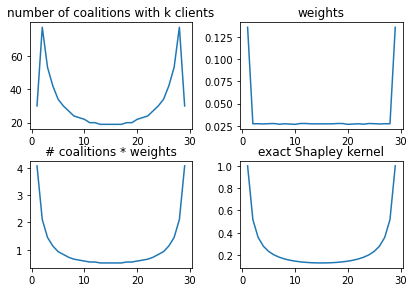

In [254]:
n_clients = 30
shap = SHAP_kernel(n_clients,900,verbose=True)
shap.forward()
print(shap.adjusted)
print(shap.weights)
discrete_shap = shap.adjusted

coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
masks,weights = coalition_object.forward()
print(masks[0])
print(weights[0])

In [121]:
print(instance_to_explain)
print(np.shape(x))

tensor([-0.4081, -0.8766, -0.8008,  0.0956, -0.1187, -0.4710, -0.5666, -0.7301,
         0.3863, -0.8411])
(455, 10)


In [92]:
print(explainer.maskMatrix)
print(explainer.kernelWeights)
print(np.shape(explainer.maskMatrix))
print(np.shape(explainer.kernelWeights))


print(masks)
print(weights)
print(np.shape(masks))
print(np.shape(weights))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [1. 0. 1.

In [263]:
# Load breast cancer data and print its shape
data = load_breast_cancer()

# Standardize dataset, split in train/test and load it into Torch dataloader
x_train, x_test, y_train, y_test = train_test_split(data.data[:,:(n_clients+1)], data.target, test_size=0.2, random_state=85)
print(np.shape(x_train))
scaler = StandardScaler()
transformed = scaler.fit_transform(x_train)

train = data_utils.TensorDataset(torch.from_numpy(transformed).float(),
                                 torch.from_numpy(y_train).float())
dataloader = data_utils.DataLoader(train, batch_size=128, shuffle=False)
scaler = StandardScaler()
transformed = scaler.fit_transform(x_test)

test_set = torch.from_numpy(transformed).float()
test_valid = torch.from_numpy(y_test).float()

(455, 30)


In [37]:
def create_model(layer_dims):
    model = torch.nn.Sequential()
    for idx, dim in enumerate(layer_dims):
        if (idx < len(layer_dims) - 1):
            module = torch.nn.Linear(dim, layer_dims[idx + 1])
            init.xavier_normal(module.weight)
            model.add_module("linear" + str(idx), module)
        else:
            model.add_module("sig" + str(idx), torch.nn.Sigmoid())
        if (idx < len(layer_dims) - 2):
            model.add_module("relu" + str(idx), torch.nn.ReLU())

    return model

In [264]:
## Create model and hyper parameters
dim_in = x_train.shape[1]
dim_out = 1

layer_dims = [dim_in, 20, 10, dim_out]

model = create_model(layer_dims)

loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 0.0007
n_epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Now run model
history = { "loss": [], "accuracy": [], "loss_val": [], "accuracy_val": [] }
for epoch in range(n_epochs):
    loss = None

    for idx, (minibatch, target) in enumerate(dataloader):
        y_pred = model(Variable(minibatch))

        loss = loss_fn(y_pred, Variable(target.float()).unsqueeze(1))

        prediction = [1 if x > 0.5 else 0 for x in y_pred.data.numpy()]
        correct = (prediction == target.numpy()).sum()
        
        # This can be uncommented for a per mini batch feedback
        #history["loss"].append(loss.data[0])
        #history["accuracy"].append(100 * correct / len(prediction))
        
        y_val_pred = model(Variable(test_set))
        loss_val = loss_fn(y_val_pred, Variable(test_valid.float()).unsqueeze(1))
        prediction_val = [1 if x > 0.5 else 0 for x in y_val_pred.data.numpy()]
        correct_val = (prediction_val == test_valid.numpy()).sum()
        
        # This can be uncommented for a per mini batch feedback
        #history["loss_val"].append(loss_val.data[0])
        #history["accuracy_val"].append(100 * correct_val / len(prediction_val))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    history["loss"].append(loss.detach().cpu().numpy())
    history["accuracy"].append(100 * correct / len(prediction))
    history["loss_val"].append(loss_val.detach().cpu().numpy())
    history["accuracy_val"].append(100 * correct_val / len(prediction_val))
    print("Loss, accuracy, val loss, val acc at epoch", epoch + 1,history["loss"][-1], 
          history["accuracy"][-1], history["loss_val"][-1], history["accuracy_val"][-1] )


index, value = max(enumerate(history["accuracy_val"]), key=operator.itemgetter(1))

print("Best accuracy was {} at iteration {}".format(value, index))


/tmp/ipykernel_2976669/3960200099.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(module.weight)
/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Loss, accuracy, val loss, val acc at epoch 1 19.158373 36.61971830985915 31.878298 34.21052631578947
Loss, accuracy, val loss, val acc at epoch 2 18.222645 39.436619718309856 30.466404 39.473684210526315
Loss, accuracy, val loss, val acc at epoch 3 17.325396 49.29577464788732 29.109861 46.49122807017544
Loss, accuracy, val loss, val acc at epoch 4 16.484566 50.70422535211268 27.80089 52.63157894736842
Loss, accuracy, val loss, val acc at epoch 5 15.716959 59.15492957746479 26.539585 59.64912280701754
Loss, accuracy, val loss, val acc at epoch 6 14.976494 64.78873239436619 25.35872 67.54385964912281
Loss, accuracy, val loss, val acc at epoch 7 14.235081 74.64788732394366 24.221355 71.05263157894737
Loss, accuracy, val loss, val acc at epoch 8 13.514464 83.09859154929578 23.10157 78.0701754385965
Loss, accuracy, val loss, val acc at epoch 9 12.809391 90.14084507042253 21.964735 80.70175438596492
Loss, accuracy, val loss, val acc at epoch 10 12.115658 94.36619718309859 20.86991 84.2105263

Loss, accuracy, val loss, val acc at epoch 89 1.0926553 97.1830985915493 4.1036215 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 90 1.0801578 97.1830985915493 4.090623 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 91 1.0678415 97.1830985915493 4.0785193 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 92 1.0557848 97.1830985915493 4.06812 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 93 1.0438507 97.1830985915493 4.0588527 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 94 1.0321803 97.1830985915493 4.0504603 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 95 1.0206535 97.1830985915493 4.042772 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 96 1.0091146 97.1830985915493 4.035507 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 97 0.9975846 98.59154929577464 4.0285735 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 98 0.9861414 98.59154929577464 4.0223775 94.73684210

Loss, accuracy, val loss, val acc at epoch 178 0.3076071 100.0 4.171808 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 179 0.30213076 100.0 4.1678953 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 180 0.29694882 100.0 4.1641555 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 181 0.29213315 100.0 4.161752 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 182 0.28753754 100.0 4.161072 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 183 0.28309658 100.0 4.1605177 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 184 0.2788837 100.0 4.1600475 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 185 0.27465558 100.0 4.158535 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 186 0.270135 100.0 4.1563225 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 187 0.26575187 100.0 4.154796 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 188 0.26170638 100.0 4.153658 96.4912280701754

Loss, accuracy, val loss, val acc at epoch 268 0.08820869 100.0 3.8101826 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 269 0.0873524 100.0 3.805632 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 270 0.08645023 100.0 3.8009522 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 271 0.085594915 100.0 3.796067 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 272 0.08476005 100.0 3.7910876 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 273 0.08394997 100.0 3.78595 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 274 0.08321138 100.0 3.7811432 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 275 0.08239749 100.0 3.7761428 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 276 0.081662506 100.0 3.7718463 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 277 0.0809075 100.0 3.767337 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 278 0.080098756 100.0 3.7618902 97.3684210

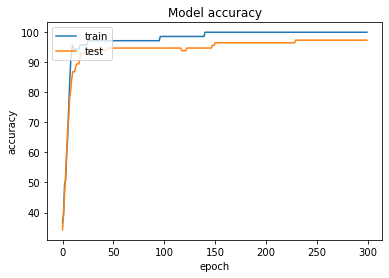

In [265]:
# Print the loss curves 
plt.plot(history['accuracy'])
plt.plot(history['accuracy_val'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [266]:
instance_to_explain = test_set[0,:] #.detach().cpu().numpy() #x_test[0]
print(instance_to_explain)
     
y_val_pred = model(Variable(instance_to_explain))
print(f"model score for the prediction to be explained: f{instance_to_explain}={y_val_pred[0]:.3f}")

x = scaler.fit_transform(x_train)




tensor([-0.9102, -0.4081, -0.8766, -0.8008,  0.0956, -0.1187, -0.4710, -0.5666,
        -0.7301,  0.3863, -0.8411,  0.6534, -0.7727, -0.5698,  0.5024,  0.3104,
         0.3529,  0.1498, -0.8948, -0.0774, -0.9539,  0.1766, -0.9011, -0.7920,
         0.6129,  0.0140, -0.2957, -0.2589, -0.9297,  0.0606])
model score for the prediction to be explained: ftensor([-0.9102, -0.4081, -0.8766, -0.8008,  0.0956, -0.1187, -0.4710, -0.5666,
        -0.7301,  0.3863, -0.8411,  0.6534, -0.7727, -0.5698,  0.5024,  0.3104,
         0.3529,  0.1498, -0.8948, -0.0774, -0.9539,  0.1766, -0.9011, -0.7920,
         0.6129,  0.0140, -0.2957, -0.2589, -0.9297,  0.0606])=1.000


In [267]:

class Data:
    def __init__(self):
        pass
    
class DenseData(Data):
    def __init__(self, data, group_names, *args):
        self.groups = args[0] if len(args) > 0 and args[0] is not None else [np.array([i]) for i in range(len(group_names))]

        l = sum(len(g) for g in self.groups)
        num_samples = data.shape[0]
        t = False
        if l != data.shape[1]:
            t = True
            num_samples = data.shape[1]

        valid = (not t and l == data.shape[1]) or (t and l == data.shape[0])
        assert valid, "# of names must match data matrix!"

        self.weights = args[1] if len(args) > 1 else np.ones(num_samples)
        self.weights /= np.sum(self.weights)
        wl = len(self.weights)
        valid = (not t and wl == data.shape[0]) or (t and wl == data.shape[1])
        assert valid, "# weights must match data matrix!"

        self.transposed = t
        self.group_names = group_names
        self.data = data
        self.groups_size = len(self.groups)
        
def convert_to_data(val, keep_index=False):
    if isinstance(val, Data):
        return val
    elif type(val) == np.ndarray:
        return DenseData(val, [str(i) for i in range(val.shape[1])])
    elif str(type(val)).endswith("'pandas.core.series.Series'>"):
        return DenseData(val.values.reshape((1,len(val))), list(val.index))
    elif str(type(val)).endswith("'pandas.core.frame.DataFrame'>"):
        if keep_index:
            return DenseDataWithIndex(val.values, list(val.columns), val.index.values, val.index.name)
        else:
            return DenseData(val.values, list(val.columns))
    ##elif sp.sparse.issparse(val):
    #    if not sp.sparse.isspmatrix_csr(val):
    #        val = val.tocsr()
     #   return SparseData(val)
    else:
        assert False, "Unknown type passed as data object: "+str(type(val))
        
class Model:
    def __init__(self, f, out_names):
        self.f = f
        self.out_names = out_names


def convert_to_model(val):
    if isinstance(val, Model):
        return val
    else:
        return Model(val, None)
    
def match_model_to_data(model, data):
    assert isinstance(model, Model), "model must be of type Model!"
    
    try:
        #if isinstance(data, DenseDataWithIndex):
        #    out_val = model.f(data.convert_to_df())
        #else:
        out_val = model.f(data.data)
    except:
        print("Provided model function fails when applied to the provided data set.")
        raise

    if model.out_names is None:
        if len(out_val.shape) == 1:
            model.out_names = ["output value"]
        else:
            model.out_names = ["output value "+str(i) for i in range(out_val.shape[0])]
    
    return out_val

class Instance:
    def __init__(self, x, group_display_values):
        self.x = x
        self.group_display_values = group_display_values


def convert_to_instance(val):
    if isinstance(val, Instance):
        return val
    else:
        return Instance(val, None)
    
def match_instance_to_data(instance, data):
    assert isinstance(instance, Instance), "instance must be of type Instance!"

    if isinstance(data, DenseData):
        if instance.group_display_values is None:
            instance.group_display_values = [instance.x[0, group[0]] if len(group) == 1 else "" for group in data.groups]
        assert len(instance.group_display_values) == len(data.groups)
        instance.groups = data.groups

In [268]:
import copy 
class Kernel(object):
    """Uses the Kernel SHAP method to explain the output of any function.
    Kernel SHAP is a method that uses a special weighted linear regression
    to compute the importance of each feature. The computed importance values
    are Shapley values from game theory and also coefficents from a local linear
    regression.
    Parameters
    ----------
    model : function or iml.Model
        User supplied function that takes a matrix of samples (# samples x # features) and
        computes a the output of the model for those samples. The output can be a vector
        (# samples) or a matrix (# samples x # model outputs).
    data : numpy.array or pandas.DataFrame or shap.common.DenseData or any scipy.sparse matrix
        The background dataset to use for integrating out features. To determine the impact
        of a feature, that feature is set to "missing" and the change in the model output
        is observed. Since most models aren't designed to handle arbitrary missing data at test
        time, we simulate "missing" by replacing the feature with the values it takes in the
        background dataset. So if the background dataset is a simple sample of all zeros, then
        we would approximate a feature being missing by setting it to zero. For small problems
        this background dataset can be the whole training set, but for larger problems consider
        using a single reference value or using the kmeans function to summarize the dataset.
        Note: for sparse case we accept any sparse matrix but convert to lil format for
        performance.
    link : "identity" or "logit"
        A generalized linear model link to connect the feature importance values to the model
        output. Since the feature importance values, phi, sum up to the model output, it often makes
        sense to connect them to the output with a link function where link(output) = sum(phi).
        If the model output is a probability then the LogitLink link function makes the feature
        importance values have log-odds units. ### Not relevant for us 
    Examples
    --------
    See :ref:`Kernel Explainer Examples <kernel_explainer_examples>`
    """

    def __init__(self, model, data, **kwargs):

        # convert incoming inputs to standardized iml objects
        self.model = convert_to_model(model)
        #self.model = model 
        self.keep_index = kwargs.get("keep_index", False)
        self.keep_index_ordered = kwargs.get("keep_index_ordered", False)
        #self.data = data 
        #model_null = self.model 
        self.data = convert_to_data(data, keep_index=self.keep_index)
        model_null = match_model_to_data(self.model, self.data)

        # warn users about large background data sets
        if len(self.data.weights) > 100:
            print("Using " + str(len(self.data.weights)) + " background data samples could cause " +
                        "slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to " +
                        "summarize the background as K samples.")

        # init our parameters
        self.N = self.data.data.shape[0]
        self.P = self.data.data.shape[1]
        self.nsamplesAdded = 0
        self.nsamplesRun = 0

        # find E_x[f(x)]
        if isinstance(model_null, (pd.DataFrame, pd.Series)):
            model_null = np.squeeze(model_null.values)
            model_null = model_null.numpy()
        self.fnull = np.sum((model_null.T * self.data.weights).T, 0)
        self.expected_value = self.fnull

        # see if we have a vector output
        self.vector_out = True
        if len(self.fnull.shape) == 0:
            self.vector_out = False
            self.fnull = np.array([self.fnull])
            self.D = 1
            self.expected_value = float(self.expected_value)
        else:
            self.D = self.fnull.shape[0]
            
    def varying_groups(self, x):
        varying_indices = []
        # go over all nonzero columns in background and evaluation data
        # if both background and evaluation are zero, the column does not vary
        varying_indices = np.unique(np.union1d(self.data.data.nonzero()[1], x.nonzero()[1]))
        remove_unvarying_indices = []
        for i in range(0, len(varying_indices)):
            varying_index = varying_indices[i]
            # now verify the nonzero values do vary
            data_rows = self.data.data[:, [varying_index]]
            nonzero_rows = data_rows.nonzero()[0]

            if nonzero_rows.size > 0:
                background_data_rows = data_rows[nonzero_rows]
                num_mismatches = np.sum(np.abs(background_data_rows - x[0, varying_index]) > 1e-7)
                # Note: If feature column non-zero but some background zero, can't remove index
                if num_mismatches == 0 and not \
                    (np.abs(x[0, [varying_index]][0, 0]) > 1e-7 and len(nonzero_rows) < data_rows.shape[0]):
                    remove_unvarying_indices.append(i)
        mask = np.ones(len(varying_indices), dtype=bool)
        mask[remove_unvarying_indices] = False
        varying_indices = varying_indices[mask]
        return varying_indices
            
    def allocate(self):
        self.synth_data = np.tile(self.data.data, (self.nsamples, 1))

        self.maskMatrix = np.zeros((self.nsamples, self.M))
        self.kernelWeights = np.zeros(self.nsamples)
        self.y = np.zeros((self.nsamples * self.N, self.D))
        self.ey = np.zeros((self.nsamples, self.D))
        self.lastMask = np.zeros(self.nsamples)
        self.nsamplesAdded = 0
        self.nsamplesRun = 0
        if self.keep_index:
            self.synth_data_index = np.tile(self.data.index_value, self.nsamples)
    def addsample(self, x, m, w):
        offset = self.nsamplesAdded * self.N
        if isinstance(self.varyingFeatureGroups, (list,)):
            for j in range(self.M):
                for k in self.varyingFeatureGroups[j]:
                    if m[j] == 1.0:
                        self.synth_data[offset:offset+self.N, k] = x[0, k]
        else:
            # for non-jagged numpy array we can significantly boost performance
            mask = m == 1.0
            groups = self.varyingFeatureGroups[mask]
            if len(groups.shape) == 2:
                for group in groups:
                    self.synth_data[offset:offset+self.N, group] = x[0, group]
            else:
                # further performance optimization in case each group has a single feature
                evaluation_data = x[0, groups]
                self.synth_data[offset:offset+self.N, groups] = evaluation_data
        self.maskMatrix[self.nsamplesAdded, :] = m
        self.kernelWeights[self.nsamplesAdded] = w
        self.nsamplesAdded += 1
        
    def addsample2(self, x, m):
        offset = self.nsamplesAdded * self.N
        if isinstance(self.varyingFeatureGroups, (list,)):
            for j in range(self.M):
                for k in self.varyingFeatureGroups[j]:
                    if m[j] == 1.0:
                        self.synth_data[offset:offset+self.N, k] = x[0, k]
        else:
            # for non-jagged numpy array we can significantly boost performance
            mask = m == 1.0
            groups = self.varyingFeatureGroups[mask]
            if len(groups.shape) == 2:
                for group in groups:
                    self.synth_data[offset:offset+self.N, group] = x[0, group]
            else:
                # further performance optimization in case each group has a single feature
                evaluation_data = x[0, groups]
                self.synth_data[offset:offset+self.N, groups] = evaluation_data
        self.maskMatrix[self.nsamplesAdded, :] = m
        self.nsamplesAdded += 1

    def shap_values(self, X, kernelshap=True,**kwargs):
        """ Estimate the SHAP values for a set of samples.
        Parameters
        ----------
        X : numpy.array or pandas.DataFrame or any scipy.sparse matrix
            A matrix of samples (# samples x # features) on which to explain the model's output.
        nsamples : "auto" or int
            Number of times to re-evaluate the model when explaining each prediction. More samples
            lead to lower variance estimates of the SHAP values. The "auto" setting uses
            `nsamples = 2 * X.shape[1] + 2048`.
        l1_reg : "num_features(int)", "auto" (default for now, but deprecated), "aic", "bic", or float
            The l1 regularization to use for feature selection (the estimation procedure is based on
            a debiased lasso). The auto option currently uses "aic" when less that 20% of the possible sample
            space is enumerated, otherwise it uses no regularization. THE BEHAVIOR OF "auto" WILL CHANGE
            in a future version to be based on num_features instead of AIC.
            The "aic" and "bic" options use the AIC and BIC rules for regularization.
            Using "num_features(int)" selects a fix number of top features. Passing a float directly sets the
            "alpha" parameter of the sklearn.linear_model.Lasso model used for feature selection.
            
        gc_collect : bool
           Run garbage collection after each explanation round. Sometime needed for memory intensive explanations (default False).
        Returns
        -------
        array or list
            For models with a single output this returns a matrix of SHAP values
            (# samples x # features). Each row sums to the difference between the model output for that
            sample and the expected value of the model output (which is stored as expected_value
            attribute of the explainer). For models with vector outputs this returns a list
            of such matrices, one for each output.
        """

        # convert dataframes
        if str(type(X)).endswith("pandas.core.series.Series'>"):
            X = X.values
        elif str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
            if self.keep_index:
                index_value = X.index.values
                index_name = X.index.name
                column_name = list(X.columns)
            X = X.values

        x_type = str(type(X))
        arr_type = "'numpy.ndarray'>"
        assert len(X.shape) == 1 or len(X.shape) == 2, "Instance must have 1 or 2 dimensions!"

        # single instance
        if len(X.shape) == 1:
            
            
            data = X.reshape((1, X.shape[0]))
            if self.keep_index:
                data = convert_to_instance_with_index(data, column_name, index_name, index_value)
            if kernelshap == True: 
                explanation = self.explain(data, **kwargs)
            else: 
                explanation = self.explain(data, kernelshap=kernelshap,weights=weights,masks=masks,nsamples=n_samples)

            # vector-output 
            s = explanation.shape
            if len(s) == 2:
                outs = [np.zeros(s[0]) for j in range(s[1])]
                for j in range(s[1]):
                    outs[j] = explanation[:, j]
                return outs

            # single-output
            else:
                out = np.zeros(s[0])
                out[:] = explanation
                return out

        # explain the whole dataset
        elif len(X.shape) == 2:
            print('shape is 2 ')
            breakpoint()
            explanations = []
            for i in tqdm(range(X.shape[0]), disable=kwargs.get("silent", False)):
                data = X[i:i + 1, :]
                if self.keep_index:
                    data = convert_to_instance_with_index(data, column_name, index_value[i:i + 1], index_name)
                explanations.append(self.explain(data, **kwargs))
                if kwargs.get("gc_collect", False):
                    gc.collect()

            # vector-output
            s = explanations[0].shape
            if len(s) == 2:
                outs = [np.zeros((X.shape[0], s[0])) for j in range(s[1])]
                for i in range(X.shape[0]):
                    for j in range(s[1]):
                        outs[j][i] = explanations[i][:, j]
                return outs

            # single-output
            else:
                out = np.zeros((X.shape[0], s[0]))
                for i in range(X.shape[0]):
                    out[i] = explanations[i]
                return out
            
    def explain(self, incoming_instance, kernelshap=True,weights=None,masks=None,n_samples="auto",**kwargs):
        # convert incoming input to a standardized iml object
        instance = convert_to_instance(incoming_instance)
        match_instance_to_data(instance, self.data)

        # find the feature groups we will test. If a feature does not change from its
        # current value then we know it doesn't impact the model
        self.varyingInds = self.varying_groups(instance.x)
        if self.data.groups is None:
            self.varyingFeatureGroups = np.array([i for i in self.varyingInds])
            self.M = self.varyingFeatureGroups.shape[0]
        else:
            self.varyingFeatureGroups = [self.data.groups[i] for i in self.varyingInds]
            self.M = len(self.varyingFeatureGroups)
            groups = self.data.groups
            # convert to numpy array as it is much faster if not jagged array (all groups of same length)
            if self.varyingFeatureGroups and all(len(groups[i]) == len(groups[0]) for i in self.varyingInds):
                self.varyingFeatureGroups = np.array(self.varyingFeatureGroups)
                # further performance optimization in case each group has a single value
                if self.varyingFeatureGroups.shape[1] == 1:
                    self.varyingFeatureGroups = self.varyingFeatureGroups.flatten()

        # find f(x)
        if self.keep_index:
            model_out = self.model.f(instance.convert_to_df())
        else:
            model_out = self.model.f(instance.x)
        if isinstance(model_out, (pd.DataFrame, pd.Series)):
            model_out = model_out.values
        self.fx = model_out[0]

        if not self.vector_out:
            self.fx = np.array([self.fx])

        # if no features vary then no feature has an effect
        if self.M == 0:
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))

        # if only one feature varies then it has all the effect
        elif self.M == 1:
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))
            diff = self.link.f(self.fx) - self.link.f(self.fnull)
            for d in range(self.D):
                phi[self.varyingInds[0],d] = diff[d]

        # if more than one feature varies then we have to do real work
        else:
            self.l1_reg = kwargs.get("l1_reg", "auto")

            # pick a reasonable number of samples if the user didn't specify how many they wanted
            self.nsamples = kwargs.get("nsamples", "auto")
            if self.nsamples == "auto":
                self.nsamples = 2 * self.M + 2**11

            # if we have enough samples to enumerate all subsets then ignore the unneeded samples
            self.max_samples = 2 ** 30
           # print('M',self.M)
            if self.M <= 30:
                #print('less than 30')
                self.max_samples = 2 ** self.M - 2
                if self.nsamples > self.max_samples:
                    self.nsamples = self.max_samples
                    
        self.allocate()
        if kernelshap == True: 
             # weight the different subset sizes
            num_subset_sizes = int(np.ceil((self.M - 1) / 2.0))
            num_paired_subset_sizes = int(np.floor((self.M - 1) / 2.0))
            weight_vector = np.array([(self.M - 1.0) / (i * (self.M - i)) for i in range(1, num_subset_sizes + 1)])
            weight_vector[:num_paired_subset_sizes] *= 2
            weight_vector /= np.sum(weight_vector)
            self.weight_vector = weight_vector 

            # fill out all the subset sizes we can completely enumerate
            # given nsamples*remaining_weight_vector[subset_size]
            num_full_subsets = 0
            num_samples_left = self.nsamples
            group_inds = np.arange(self.M, dtype='int64')
            mask = np.zeros(self.M)
            remaining_weight_vector = copy.copy(weight_vector)
            for subset_size in range(1, num_subset_sizes + 1):

                # determine how many subsets (and their complements) are of the current size
                nsubsets = binom(self.M, subset_size)
                if subset_size <= num_paired_subset_sizes: nsubsets *= 2

                # see if we have enough samples to enumerate all subsets of this size
                if num_samples_left * remaining_weight_vector[subset_size - 1] / nsubsets >= 1.0 - 1e-8:
                    num_full_subsets += 1
                    num_samples_left -= nsubsets


                    # rescale what's left of the remaining weight vector to sum to 1
                    if remaining_weight_vector[subset_size - 1] < 1.0:
                        remaining_weight_vector /= (1 - remaining_weight_vector[subset_size - 1])


                    # add all the samples of the current subset size
                    w = weight_vector[subset_size - 1] / binom(self.M, subset_size)
                    if subset_size <= num_paired_subset_sizes: w /= 2.0
                    for inds in itertools.combinations(group_inds, subset_size):
                        mask[:] = 0.0
                        mask[np.array(inds, dtype='int64')] = 1.0
                        self.addsample(instance.x, mask, w)
                        if subset_size <= num_paired_subset_sizes:
                            mask[:] = np.abs(mask - 1)
                            self.addsample(instance.x, mask, w)

                else:
                    break

            # add random samples from what is left of the subset space
            nfixed_samples = self.nsamplesAdded
            samples_left = self.nsamples - self.nsamplesAdded

            if num_full_subsets != num_subset_sizes:
                remaining_weight_vector = copy.copy(weight_vector)

                remaining_weight_vector[:num_paired_subset_sizes] /= 2 # because we draw two samples each below
                remaining_weight_vector = remaining_weight_vector[num_full_subsets:]
                remaining_weight_vector /= np.sum(remaining_weight_vector)

                ind_set = np.random.choice(len(remaining_weight_vector), 4 * samples_left, p=remaining_weight_vector)
                ind_set_pos = 0
                used_masks = {}
                while samples_left > 0 and ind_set_pos < len(ind_set):
                    mask.fill(0.0)
                    ind = ind_set[ind_set_pos] # we call np.random.choice once to save time and then just read it here
                    ind_set_pos += 1
                    subset_size = ind + num_full_subsets + 1
                    mask[np.random.permutation(self.M)[:subset_size]] = 1.0

                    # only add the sample if we have not seen it before, otherwise just
                    # increment a previous sample's weight
                    mask_tuple = tuple(mask)
                    new_sample = False
                    if mask_tuple not in used_masks:
                        new_sample = True
                        used_masks[mask_tuple] = self.nsamplesAdded
                        samples_left -= 1
                        self.addsample(instance.x, mask, 1.0)
                    else:
                        self.kernelWeights[used_masks[mask_tuple]] += 1.0

                    # add the compliment sample
                    if samples_left > 0 and subset_size <= num_paired_subset_sizes:
                        mask[:] = np.abs(mask - 1)

                        # only add the sample if we have not seen it before, otherwise just
                        # increment a previous sample's weight
                        if new_sample:
                            samples_left -= 1
                            self.addsample(instance.x, mask, 1.0)
                        else:
                            # we know the compliment sample is the next one after the original sample, so + 1
                            self.kernelWeights[used_masks[mask_tuple] + 1] += 1.0

                # normalize the kernel weights for the random samples to equal the weight left after
                # the fixed enumerated samples have been already counted
                weight_left = np.sum(weight_vector[num_full_subsets:])
          #      print("weight_left = {0}".format(weight_left))
                self.kernelWeights[nfixed_samples:] *= weight_left / self.kernelWeights[nfixed_samples:].sum()
        else: 
            self.kernelWeights = weights 
            self.maskMatrix = masks 
          #  print(self.synth_data[:10,:10])
            for mask in masks: 
                self.addsample2(instance.x,mask)
          #  print(self.synth_data[:10,:10])
        # execute the model on the synthetic samples we have created
        self.run()
        
        # solve then expand the feature importance (Shapley value) vector to contain the non-varying features
        phi = np.zeros((self.data.groups_size, self.D))
        phi_var = np.zeros((self.data.groups_size, self.D))
        for d in range(self.D):
            vphi, vphi_var = self.solve(self.nsamples / self.max_samples, d)
            phi[self.varyingInds, d] = vphi
            phi_var[self.varyingInds, d] = vphi_var
        return phi 
        
    def run(self):
        #print("N: ",self.N)
        #print("nsamplesadded ",self.nsamplesAdded)
        #print("nsamplesrun ",self.nsamplesRun)
        #print("nsamples ",self.nsamples)
        
        #self.nsamplesAdded = 1022
        #print(np.shape(self.synth_data))
        num_to_run = self.nsamplesAdded * self.N - self.nsamplesRun * self.N
        data = self.synth_data[self.nsamplesRun*self.N:self.nsamplesAdded*self.N,:]
        #print("self..",self.nsamplesRun*self.N)
        #print("self..",self.nsamplesAdded*self.N)
        #print(data)
      
        if self.keep_index:
            index = self.synth_data_index[self.nsamplesRun*self.N:self.nsamplesAdded*self.N]
            index = pd.DataFrame(index, columns=[self.data.index_name])
            data = pd.DataFrame(data, columns=self.data.group_names)
            data = pd.concat([index, data], axis=1).set_index(self.data.index_name)
            if self.keep_index_ordered:
                data = data.sort_index()
        modelOut = self.model.f(data)
        if isinstance(modelOut, (pd.DataFrame, pd.Series)):
            modelOut = modelOut.values
        self.y[self.nsamplesRun * self.N:self.nsamplesAdded * self.N, :] = np.reshape(modelOut, (num_to_run, self.D))
       # print("y ",np.shape(self.y))
       # print(self.y)
        # find the expected value of each output
        for i in range(self.nsamplesRun, self.nsamplesAdded):
            eyVal = np.zeros(self.D)
            for j in range(0, self.N):
                eyVal += self.y[i * self.N + j, :] * self.data.weights[j]

            self.ey[i, :] = eyVal
            self.nsamplesRun += 1

    def solve(self, fraction_evaluated, dim):
        #print("ey: ",np.shape(self.ey))
        #print(self.ey)
        eyAdj = self.ey[:, dim] - self.fnull[dim]
        
        s = np.sum(self.maskMatrix, 1)
        #print("maskmatrix",np.shape(self.maskMatrix))
        #print("eyAdj",np.shape(eyAdj))
        #print(eyAdj)

        # do feature selection if we have not well enumerated the space
        nonzero_inds = np.arange(self.M)

        # eliminate one variable with the constraint that all features sum to the output
        eyAdj2 = eyAdj - self.maskMatrix[:, nonzero_inds[-1]] * (
                    (self.fx[dim]) - (self.fnull[dim]))

        etmp = np.transpose(np.transpose(self.maskMatrix[:, nonzero_inds[:-1]]) - self.maskMatrix[:, nonzero_inds[-1]])
        #print("etmp ",np.shape(etmp))
        #print(etmp)
        
        # solve a weighted least squares equation to estimate phi
        tmp = np.transpose(np.transpose(etmp) * np.transpose(self.kernelWeights))
        #print("tmp ",np.shape(tmp))
        etmp_dot = np.dot(np.transpose(tmp), etmp)
        try:
            tmp2 = np.linalg.inv(etmp_dot)
        except np.linalg.LinAlgError:
            tmp2 = np.linalg.pinv(etmp_dot)
            warnings.warn(
                "Linear regression equation is singular, Moore-Penrose pseudoinverse is used instead of the regular inverse.\n"
                "To use regular inverse do one of the following:\n"
                "1) turn up the number of samples,\n"
                "2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,\n"
                "3) group features together to reduce the number of inputs that need to be explained."
            )
        w = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))

        phi = np.zeros(self.M)
        phi[nonzero_inds[:-1]] = w
        phi[nonzero_inds[-1]] = ((self.fx[dim]) - (self.fnull[dim])) - sum(w)

        # clean up any rounding errors
        for i in range(self.M):
            if np.abs(phi[i]) < 1e-10:
                phi[i] = 0

        return phi, np.ones(len(phi))    

In [283]:
import itertools
from sklearn.linear_model import LassoLarsIC, Lasso, lars_path
from scipy.special import binom 
n_dim = 30
n_samples = 899

f = lambda x: model(Variable(torch.from_numpy(x).float())).detach().numpy()
explainer = Kernel(f,x[:,:n_dim])

svs = np.zeros((1,n_dim))
for ii in range(1):
    print(ii)
# The SHAP function is basically just a wrapper for the explainer function 
    sv = explainer.shap_values(instance_to_explain[:n_dim].detach().cpu().numpy(),kernelshap=True,nsamples=10000)
    #print(sv)
    #print("shapley value 1: ",sv[0])
    svs[ii,:] = sv[0] 
    
print(np.shape(explainer.maskMatrix))

svs1 = np.zeros((10,n_dim))
for ii in range(10):
    print(ii)
# The SHAP function is basically just a wrapper for the explainer function 
    sv = explainer.shap_values(instance_to_explain[:n_dim].detach().cpu().numpy(),kernelshap=True,
                              nsamples=n_samples)
    #print(sv)
    #print("shapley value 1: ",sv[0])
    svs1[ii,:] = sv[0] 
    
print(np.shape(explainer.maskMatrix))
    
svs2 = np.zeros((10,n_dim))
f = lambda x: model(Variable(torch.from_numpy(x).float())).detach().numpy()
explainer = Kernel(f,x[:,:n_dim])
for ii in range(10):
    n_clients = n_dim
    shap = SHAP_kernel(n_clients,n_samples,verbose=False)
    shap.forward()

    discrete_shap = shap.adjusted

    coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
    masks,weights = coalition_object.forward()
    sv = explainer.shap_values(instance_to_explain[:n_dim].detach().cpu().numpy(),kernelshap=False,
                              weights = weights, masks = masks,nsamples=n_samples)
    #print("shapley value 2: ",sv[0])
    print(ii)
    svs2[ii,:] = sv[0] 
    

#print('nsamples',explainer.nsamples)
#print(sv[0])


Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
0
(10000, 30)
0
1
2
3
4
5
6
7
8
9
(899, 30)
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, 'Quality of approximation for 99 samples and 10 features')

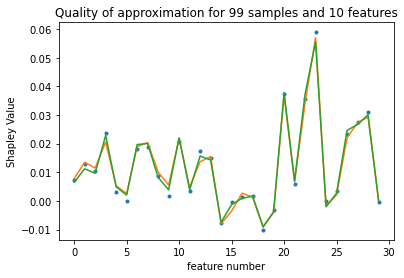

In [284]:
plt.plot(svs.T,".",label="KernelSHAP values for 2**N samples")
plt.xlabel("feature number")
plt.ylabel("Shapley Value")
plt.plot(np.mean(svs1,axis=0),label="KernelSHAP approximation")
plt.plot(np.mean(svs2,axis=0),label="my approximation")
plt.title("Quality of approximation for 99 samples and 10 features")
#plt.legend()

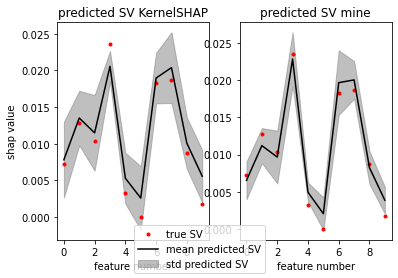

In [292]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(svs.T[:10],".r",label="true SV")
ax2.plot(svs.T[:10],".r")
ax1.plot(np.mean(svs1,axis=0)[:10],color='k',label="mean predicted SV")
ax2.plot(np.mean(svs2,axis=0)[:10],color='k')
ax1.fill_between(np.arange(n_dim)[:10],np.mean(svs1,axis=0)[:10] - np.std(svs1,axis=0)[:10],
                 np.mean(svs1,axis=0)[:10]+ np.std(svs1,axis=0)[:10],
                color='gray',alpha=0.5,label="std predicted SV")
ax2.fill_between(np.arange(n_dim)[:10],np.mean(svs2,axis=0)[:10] - np.std(svs2,axis=0)[:10],
                 np.mean(svs2,axis=0)[:10]+ np.std(svs2,axis=0)[:10],
                color='gray',alpha=0.5)
ax1.title.set_text("predicted SV KernelSHAP")
ax2.title.set_text("predicted SV mine")
ax1.set_xlabel("feature number")
ax2.set_xlabel("feature number")
ax1.set_ylabel("shap value")
#ax2.set_ylabel("shap value")
fig.legend(loc='lower center')

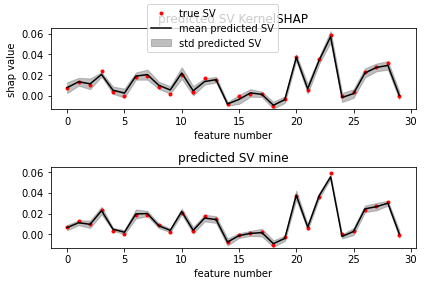

In [295]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(svs.T,".r",label="true SV")
ax2.plot(svs.T,".r")
ax1.plot(np.mean(svs1,axis=0),color='k',label="mean predicted SV")
ax2.plot(np.mean(svs2,axis=0),color='k')
ax1.fill_between(np.arange(n_dim),np.mean(svs1,axis=0)- np.std(svs1,axis=0),
                 np.mean(svs1,axis=0)+ np.std(svs1,axis=0),
                color='gray',alpha=0.5,label="std predicted SV")
ax2.fill_between(np.arange(n_dim),np.mean(svs2,axis=0) - np.std(svs2,axis=0),
                 np.mean(svs2,axis=0)+ np.std(svs2,axis=0),
                color='gray',alpha=0.5)
ax1.title.set_text("predicted SV KernelSHAP")
ax2.title.set_text("predicted SV mine")
ax1.set_xlabel("feature number")
ax2.set_xlabel("feature number")
ax1.set_ylabel("shap value")
ax1.set_ylim([-0.013,0.065])
ax2.set_ylim([-0.013,0.065])
#ax2.set_ylabel("shap value")
plt.tight_layout()
fig.legend(loc='upper center')

In [286]:
error_1 = 0 
error_2 = 0 
for sv1, sv2 in zip(svs1,svs2):
    error_1 += np.sum((sv1 - svs)**2)
    error_2 += np.sum((sv2 - svs)**2)
print(error_1)
print(error_2)

0.005550764055520671
0.0031382011310004242


In [63]:
# inspect the kernel weights and randomly selected samples 
print(explainer.kernelWeights[31])
print(explainer.maskMatrix[31, :])
print(explainer.kernelWeights[32])
print(explainer.maskMatrix[32, :])
print(explainer.kernelWeights[33])
print(explainer.maskMatrix[33, :])
print(0.7388/2048)
print("this means that this sample was probably only selected once, but there are samples that were selected multiple times")


0.002454762238743161
[0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
0.002454762238743161
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0.002454762238743161
[0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
0.0003607421875
this means that this sample was probably only selected once, but there are samples that were selected multiple times


In [290]:
### Now make the same plot for the in-built Shapley approximation
n_dim = 30
n_samples = 899
f = lambda x: model(Variable(torch.from_numpy(x).float())).detach().numpy()
explainer = Kernel(f,x[:,:n_dim])
sv = explainer.shap_values(instance_to_explain[:n_dim].detach().cpu().numpy(),kernelshap=True,nsamples=n_samples)

    
print(explainer.kernelWeights)


Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
[0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085

(899, 30)
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[30 74 57 49 29 21 33 26 19 21 24 12 21 23 22 23 21 12 24 21 19 26 33 21
 29 48 57 74 30]
[0.00435207 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085222 0.00085222 0.00435207]


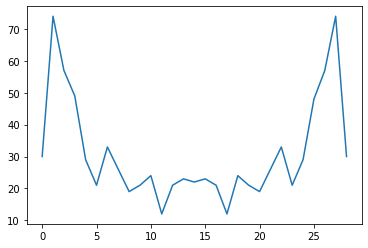

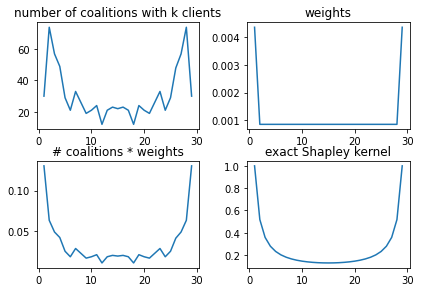

In [291]:
print(np.shape(explainer.maskMatrix))
occurrence = np.zeros(n_samples)
weights = np.zeros(n_clients-1)
for i,row in enumerate(explainer.maskMatrix):
    #print(np.sum(row))
    occurrence[i] = np.sum(row)
    weights[int(occurrence[i]-1)] = explainer.kernelWeights[i]
    #print(explainer.kernelWeights[i])
    
unique, counts = np.unique(occurrence, return_counts=True)
print(unique)
print(counts)
plt.plot(counts)
print(weights)

fig,ax = plt.subplots(2,2)
plt.tight_layout()
ax[0,0].plot(np.arange(1,n_clients),counts)
ax[0,0].title.set_text("number of coalitions with k clients")
ax[0,1].plot(np.arange(1,n_clients),weights)
ax[0,1].title.set_text("weights")
ax[1,0].plot(np.arange(1,n_clients),counts*weights)
ax[1,0].title.set_text("# coalitions * weights")
ax[1,1].plot(np.arange(1,n_clients),shap.shap_weights)
ax[1,1].title.set_text("exact Shapley kernel")